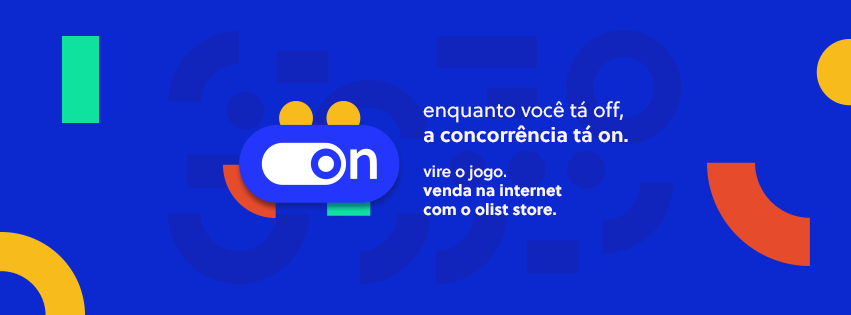

**<font color="blue">« Pendant que vous êtes au repos, la compétition est en marche.
Changez la donne. Vendez sur internet avec olist store »</font>**


**Segmentez des clients d'un site e-commerce**

Olist souhaite que vous fournissiez à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Votre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.

**Vous devrez fournir à l’équipe marketing :**
* une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale
* un devis de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps, c'est-à-dire la fréquence à laquelle la segmentation doit être mise à jour.
* Le code fourni doit respecter la convention PEP8, pour être utilisable par Olist.


**Les données :**

Pour cette mission, Olist vous fournit une base de données anonymisée comportant des informations sur 
* l’historique de commandes
* les produits achetés
* les commentaires de satisfaction
* la localisation des clients depuis janvier 2017



Le premier notebook contient les phases de Data processing, de Features Engineering et de EDA (Exploratory Data Analysis)  et le second notebook contient les phases de **modélisations non supervisées** puis les phases d'interprétation avec la **régression logistique régularisée en l1**.


DataSchema et données : https://www.kaggle.com/olistbr/brazilian-ecommerce

# <font color="#1d479b" id="section_1">Fusion des tables</font>

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings # Ignores any warning
warnings.filterwarnings("ignore")
from datetime import datetime
#pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.precision = 2
plt.rcParams['figure.figsize'] = (10, 5) #(L,l)
pd.set_option('display.max_columns', 50)

In [2]:
orders_time = pd.read_csv("olist_orders_dataset.csv",sep ="," ) 
customers_adress = pd.read_csv("olist_customers_dataset.csv",sep ="," ) 
reviews = pd.read_csv("olist_order_reviews_dataset.csv",sep ="," ) 
payments = pd.read_csv("olist_order_payments_dataset.csv",sep ="," ) 
order_items = pd.read_csv("olist_order_items_dataset.csv",sep ="," ) 
products = pd.read_csv("olist_products_dataset.csv",sep ="," ) 
sellers = pd.read_csv("olist_sellers_dataset.csv",sep ="," ) 
geolocation = pd.read_csv("olist_geolocation_dataset.csv",sep ="," ) 
translation = pd.read_csv("product_category_name_translation.csv",sep ="," ) 

## <font color="#337da4">Merge sur la clé order_id</font>

`order_items.order_id.nunique() < payments.order_id.nunique()` donc la table `order_items` est à gauche. Cela permet d'éviter les nan lors de la fusion des tables.

In [3]:
df1 = order_items.merge(payments, how='left', on='order_id') 
print(df1.shape)                                             
df2 = df1.merge(reviews, how='left', on='order_id')
print(df2.shape) 
df3= df2.merge(orders_time, how='left', on='order_id')
print(df3.shape)

(117604, 11)
(118318, 17)
(118318, 24)


## <font color="#337da4">Merge sur la clé product_id</font>

In [4]:
df4= df3.merge(products, how='left', on='product_id')
print(df4.shape)
#df4.isna().sum()

(118318, 32)


## <font color="#337da4">Merge sur la clé product_category_name</font>

In [5]:
df5= translation.merge(df4, how='left', on='product_category_name')
print(df5.shape)
#df5.isna().sum()

(116584, 33)


## <font color="#337da4">Merge sur la clé customer_id</font>

In [6]:
df6= df5.merge(customers_adress, how='left', on='customer_id')
print(df6.shape)
#df6.isna().sum()

(116584, 37)


## <font color="#337da4">Merge sur les 3 clés de la table geolocation pour customers</font>

Merge sur les clés `geolocation_zip_code_prefix` , `geolocation_city`, `geolocation_state` avec  `customer_zip_code_prefix`, `customer_city`, `customer_state`.

Il faut avant nettoyer les colonnes servant de clés pour la table df6 et la table geolocalisation:

In [7]:
df6.customer_zip_code_prefix = df6.customer_zip_code_prefix.astype(int)
df6=df6.replace({'customer_city': {"arraial d ajuda": "arraial d'ajuda",
                                  "santa barbara d oeste": "santa barbara d'oeste",
                                  "rio de janeiro \rio de janeiro" : "rio de janeiro"}})
print(df6.shape)
df6.head()

(116584, 37)


,product_category_name,product_category_name_english,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,beleza_saude,health_beauty,0005a1a1728c9d785b8e2b08b904576c,1,310ae3c140ff94b03219ad0adc3c778f,a416b6a846a11724393025641d4edd5e,2018-03-26 18:31:29,145.95,11.65,1.0,credit_card,3.0,157.60,67b1ab8f3ec19d5a90f153f21757d3a1,1,NaN,Na descrição do produto quando fui efetuar a c...,2018-03-30 00:00:00,2018-04-02 00:52:01,16150771dfd4776261284213b89c304e,delivered,2018-03-19 18:40:33,2018-03-20 18:35:21,2018-03-28 00:37:42,2018-03-29 18:17:31,2018-03-29 00:00:00,59.0,493.0,1.0,2000.0,30.0,12.0,16.0,639d23421f5517f69d0c3d6e6564cf0e,11075,santos,SP
1,beleza_saude,health_beauty,00061f2a7bc09da83e415a52dc8a4af1,1,d63c1011f49d98b976c352955b1c4bea,cc419e0650a3c5ba77189a1882b7556a,2018-03-29 22:28:09,59.99,8.88,1.0,credit_card,3.0,68.87,7e92c32ae297ef950ee69781d9f1760c,5,NaN,A caixa do produto veio com uma pequena avaria...,2018-03-30 00:00:00,2018-03-30 04:04:56,c6fc061d86fab1e2b2eac259bac71a49,delivered,2018-03-24 22:16:10,2018-03-24 22:28:09,2018-03-27 05:26:55,2018-03-29 00:04:19,2018-04-09 00:00:00,57.0,614.0,1.0,950.0,35.0,25.0,20.0,107e6259485efac66428a56f10801f4f,13419,piracicaba,SP
2,beleza_saude,health_beauty,001d8f0e34a38c37f7dba2a37d4eba8b,1,e67307ff0f15ade43fcb6e670be7a74c,f4aba7c0bca51484c30ab7bdc34bcdd1,2017-05-18 17:35:11,18.99,7.78,1.0,credit_card,2.0,53.54,51ebb8fede4fbe6126f9f85ebdd23166,1,NaN,Entrega prometida 24/05/17. Dia 26/05/17 não h...,2017-05-26 00:00:00,2017-05-26 20:19:13,d987da9fb4086ab7c2c0f83963cd6722,delivered,2017-05-14 17:19:44,2017-05-14 17:35:11,2017-05-24 15:45:01,2017-05-26 13:14:50,2017-05-24 00:00:00,47.0,1474.0,3.0,150.0,43.0,13.0,14.0,870a0bdc769f9a7870309036740e79ea,2929,sao paulo,SP
3,beleza_saude,health_beauty,001d8f0e34a38c37f7dba2a37d4eba8b,2,e67307ff0f15ade43fcb6e670be7a74c,f4aba7c0bca51484c30ab7bdc34bcdd1,2017-05-18 17:35:11,18.99,7.78,1.0,credit_card,2.0,53.54,51ebb8fede4fbe6126f9f85ebdd23166,1,NaN,Entrega prometida 24/05/17. Dia 26/05/17 não h...,2017-05-26 00:00:00,2017-05-26 20:19:13,d987da9fb4086ab7c2c0f83963cd6722,delivered,2017-05-14 17:19:44,2017-05-14 17:35:11,2017-05-24 15:45:01,2017-05-26 13:14:50,2017-05-24 00:00:00,47.0,1474.0,3.0,150.0,43.0,13.0,14.0,870a0bdc769f9a7870309036740e79ea,2929,sao paulo,SP
4,beleza_saude,health_beauty,001e7cf2ad6bef3ade12ebc56ceaf0f3,1,bdcf6a834e8faa30dac3886c7a58e92e,2a84855fd20af891be03bc5924d2b453,2018-05-22 10:59:50,35.90,15.20,1.0,credit_card,2.0,51.10,048baba3f11436d12b06dab572aafc21,1,Pessima,O produto chegou e estragou sozinho,2018-06-05 00:00:00,2018-06-06 19:01:54,d1684ed69f8fd574b7c344de923f379a,delivered,2018-05-19 10:29:23,2018-05-19 10:59:50,2018-05-21 14:34:00,2018-06-04 18:08:23,2018-06-05 00:00:00,26.0,394.0,1.0,1614.0,31.0,16.0,28.0,43860f86362fea12550bfa19ef73015f,38550,coromandel,MG


In [8]:
#Remove accents
geolocation["geolocation_city"] = \
geolocation["geolocation_city"].str.normalize('NFKD').str.encode('ascii', 
                                                                 errors='ignore').str.decode('utf-8')
geolocation = geolocation[geolocation.geolocation_city != "* cidade"]
geolocation = geolocation.replace({'geolocation_city': {"...arraial do cabo": "arraial do cabo",
                                         "4o centenario" : "centenario",
                                         "4o. centenario" : "centenario",
                                         "florian&oacute;polis" : "florianopolis",
                                         " teresopolis": "teresopolis"}})
geolocation = geolocation.drop_duplicates(subset=[ "geolocation_city","geolocation_zip_code_prefix","geolocation_state"], keep='first')
print(geolocation.shape)

(19612, 5)


In [9]:
#Modify column names 
df6.rename(columns={'customer_zip_code_prefix': 'geolocation_zip_code_prefix',
                   'customer_city': 'geolocation_city',
                  'customer_state': 'geolocation_state',}, inplace=True)
df7 =  df6.merge(geolocation,how = 'inner', on=['geolocation_zip_code_prefix',
                                                "geolocation_city","geolocation_state"])
df7.rename(columns={'geolocation_zip_code_prefix': 'customer_zip_code_prefix',
                   'geolocation_city': 'customer_city',
                   'geolocation_state': 'customer_state',
                   'geolocation_lat': 'customer_lat',
                   'geolocation_lng': 'customer_lng'}, inplace=True)
print(df7.shape) 
df7.head()

(116239, 39)


,product_category_name,product_category_name_english,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_lng
0,beleza_saude,health_beauty,0005a1a1728c9d785b8e2b08b904576c,1,310ae3c140ff94b03219ad0adc3c778f,a416b6a846a11724393025641d4edd5e,2018-03-26 18:31:29,145.95,11.65,1.0,credit_card,3.0,157.60,67b1ab8f3ec19d5a90f153f21757d3a1,1,NaN,Na descrição do produto quando fui efetuar a c...,2018-03-30 00:00:00,2018-04-02 00:52:01,16150771dfd4776261284213b89c304e,delivered,2018-03-19 18:40:33,2018-03-20 18:35:21,2018-03-28 00:37:42,2018-03-29 18:17:31,2018-03-29 00:00:00,59.0,493.0,1.0,2000.0,30.0,12.0,16.0,639d23421f5517f69d0c3d6e6564cf0e,11075,santos,SP,-23.94,-46.33
1,beleza_saude,health_beauty,18846e52fc8a87bb5f3e3b353940b320,1,4c2394abfbac7ff59ec7a420918562fa,cc419e0650a3c5ba77189a1882b7556a,2017-12-26 20:12:12,84.99,9.41,1.0,credit_card,4.0,94.40,73a9c38d169fbb7c5ea8d58c744b5ed1,5,NaN,NaN,2017-12-24 00:00:00,2017-12-24 20:42:30,830886644e4e7bdc1395f0a7773a9235,delivered,2017-12-18 19:55:15,2017-12-18 20:12:12,2017-12-20 20:03:06,2017-12-23 17:23:25,2018-01-08 00:00:00,49.0,1495.0,3.0,600.0,33.0,19.0,13.0,d79331fc284179e11e0b1ecb4d39daf9,11075,santos,SP,-23.94,-46.33
2,beleza_saude,health_beauty,1ffa782d6d367937efeae11231132a6f,1,2fea0f2cec6b6324a277d4a61c2ed2c6,beadbee30901a7f61d031b6b686095ad,2018-07-05 21:31:38,46.00,7.58,1.0,credit_card,1.0,53.58,fe8bc5412216e8190e45f27a0b69a08a,5,NaN,NaN,2018-07-05 00:00:00,2018-07-07 22:28:48,c20ef58701f7d633de740985bf553b3c,delivered,2018-06-28 21:24:51,2018-06-28 21:35:17,2018-07-02 14:12:00,2018-07-04 18:58:59,2018-07-13 00:00:00,57.0,2026.0,3.0,100.0,11.0,11.0,11.0,21a1a3e9b79be7c67875aa2241bab64a,11075,santos,SP,-23.94,-46.33
3,beleza_saude,health_beauty,a9a75c64cb5e9f7bc92e68ec13f05c45,1,7e437c1d65a7baab7e7ca6c9f4e98b84,b56906f7fd1696e043f1bcce164c487b,2018-04-10 03:15:30,59.00,17.32,1.0,boleto,1.0,76.32,8c6537ae1519a3c0375e4fd45438344b,5,NaN,NaN,2018-04-06 00:00:00,2018-04-07 03:11:49,2bd2bb24b32d017bb23235299984f0b7,delivered,2018-04-03 12:39:58,2018-04-04 03:15:30,2018-04-04 20:52:36,2018-04-05 22:12:48,2018-04-20 00:00:00,57.0,1571.0,1.0,2150.0,28.0,32.0,11.0,9579583ea574e24b89b5585666fa0e2e,11075,santos,SP,-23.94,-46.33
4,beleza_saude,health_beauty,be39a554924306abfee91a4f38ac55bb,1,195a72beccf48da20d71e2d7530b470a,ea566164622c6b439516ab18062c42cd,2018-03-14 13:05:29,29.90,9.42,1.0,credit_card,1.0,0.34,fa1f034af3096484ba57c276573cac8d,5,NaN,NaN,2018-03-13 00:00:00,2018-03-16 01:29:18,e18f0839b686423535bb862e71762cf9,delivered,2018-03-08 12:49:36,2018-03-08 13:08:26,2018-03-08 23:06:30,2018-03-12 22:16:31,2018-03-20 00:00:00,48.0,474.0,4.0,425.0,20.0,11.0,14.0,6c734067f6c8d999e1a32f368fd70f13,11075,santos,SP,-23.94,-46.33


## <font color="#337da4">Merge sur la clé seller_id</font>

In [10]:
df8= df7.merge(sellers, how='left', on='seller_id')
print(df8.shape)
#df8.isna().sum()

(116239, 42)


## <font color="#337da4">Merge sur les 3 clés de la table geolocation pour sellers</font>

Merge sur les clés `geolocation_zip_code_prefix` , `geolocation_city`, `geolocation_state` avec  `seller_zip_code_prefix`, `seller_city`, `seller_state`.

Il faut avant nettoyer les colonnes servant de clés pour la table df8 :

In [11]:
#Replace nan by 0 
df8["seller_zip_code_prefix"] = df8["seller_zip_code_prefix"] .replace( np.nan ,0, inplace=False)
#Float to int
df8["seller_zip_code_prefix"] = df8["seller_zip_code_prefix"] .astype(int)
#Takes the first element of the list
df8["seller_city"] = df8["seller_city"].astype(str)
df8["seller_city"] = df8["seller_city"].str.split("/") 
df8["seller_city"] = df8["seller_city"].apply(lambda x : x[0])

df8 = df8.replace({'seller_city': {"04482255": "rio de janeiro",
                                         "angra dos reis rj" : "angra dos reis",
                                         "ao bernardo do campo" : "sao bernardo do campo",
                                         "arraial d'ajuda (porto seguro)" : "arraial d'ajuda",
                            "aguas claras df" : "aguas claras",
                            "brasilia df" : "brasilia",
                            "novo hamburgo, rio grande do sul, brasil" : "novo hamburgo",
                            "carapicuiba " : "carapicuiba",
                            "balenario camboriu" : "balneario camboriu",
                             "mogi das cruses":"mogi das cruzes",
                              "lages - sc":"lages",
                              "mogi das cruzes ":"mogi das cruzes",
                             "ribeirao preto ":"ribeirao preto",
                             "ribeirao pretp":"ribeirao preto",
                             "ribeirao preto ":"ribeirao preto",
                             "riberao preto":"ribeirao preto",
                             "rio de janeiro ": "rio de janeiro",
                            "rio de janeiro \rio de janeiro" : "rio de janeiro",
                            "rio de janeiro, rio de janeiro, brasil" : "rio de janeiro",
                            "rio de janeiro \\rio de janeiro": "rio de janeiro",
                            "s jose do rio preto":"sao jose do rio preto",
                            "sao paluo" : "sao paulo",
                            "são paulo" : "sao paulo",
                            "sao paulo " : "sao paulo",
                            "sao paulo - sp" : "sao paulo",
                            "sao paulo sp" : "sao paulo",
                            "sao paulop" : "sao paulo",
                            "sao pauo" : "sao paulo",
                            "sbc" : np.nan,
                            "sp" : np.nan,
                            "sp " : np.nan,
                            "tabao da serra" : "taboao da serra",
                            "endas@creditparts.com.br" : np.nan,
                            "santa barbara d oeste" : "santa barbara d'oeste",
                            "santa barbara d´oeste" : "santa barbara d'oeste"}})
print("OK")

OK


In [12]:
list(df8["seller_city"].unique())

['sao paulo',
 'santo andre',
 'guarulhos',
 'echapora',
 'sao  paulo',
 'belo horizonte',
 'cajamar',
 'joinville',
 'ibitinga',
 'piracicaba',
 'rodeio',
 'limeira',
 'indaiatuba',
 'presidente prudente',
 'ribeirao pires',
 'praia grande',
 'curitiba',
 'campinas',
 'araguari',
 'brasilia',
 'ampere',
 'barueri',
 'porto alegre',
 'sao jose do rio preto',
 'salto',
 'ilicinea',
 'santos',
 'icara',
 'itaquaquecetuba',
 'maringa',
 'teresopolis',
 'tiradentes',
 'hortolandia',
 'rio de janeiro',
 'sarandi',
 'foz do iguacu',
 'ribeirao preto',
 'vicente de carvalho',
 'sao bernardo do campo',
 'louveira',
 'colombo',
 'sumare',
 'itatiba',
 'sorocaba',
 'eunapolis',
 'guariba',
 'blumenau',
 'atibaia',
 'jacarei',
 'penapolis',
 'ponte nova',
 'canoinhas',
 'campo limpo paulista',
 'franca',
 'assis',
 'sete lagoas',
 'aracatuba',
 'itapevi',
 'sao carlos',
 'mineiros do tiete',
 'taubate',
 'canoas',
 'campo mourao',
 'formiga',
 'aparecida',
 'sao luis',
 'sao jose dos campos',
 'm

In [13]:
list(df8["customer_city"].unique())

['santos',
 'piracicaba',
 'sao paulo',
 'coromandel',
 'guarulhos',
 'mogi-guacu',
 'sao jose dos campos',
 'praia grande',
 'serrana',
 'rio de janeiro',
 'brumadinho',
 'bariri',
 'lagoa santa',
 'sao goncalo',
 'porto seguro',
 'cambui',
 'soledade de minas',
 'casimiro de abreu',
 'feira de santana',
 'santo andre',
 'pederneiras',
 'nova friburgo',
 'teresina',
 'ribeirao das neves',
 'salvador',
 'brasilia',
 'osasco',
 'florianopolis',
 'suzano',
 'araguaina',
 'viradouro',
 'morro reuter',
 'joinville',
 'porto alegre',
 'rio verde',
 'canoas',
 'varginha',
 'cristais paulista',
 'vargem grande paulista',
 'belo horizonte',
 'petropolis',
 'fortaleza',
 'uberaba',
 'curitiba',
 'duque de caxias',
 'taboao da serra',
 'piumhi',
 'itabira',
 'sao bernardo do campo',
 'cariacica',
 'vitoria da conquista',
 'patos de minas',
 'araruama',
 'camaqua',
 'sao miguel do araguaia',
 'goiania',
 'palmas',
 'presidente prudente',
 'paulinia',
 'bauru',
 'salto',
 'paripueira',
 'lucelia',

In [14]:
df8.rename(columns={'seller_zip_code_prefix': 'geolocation_zip_code_prefix',
                   'seller_city': 'geolocation_city',
                  'seller_state': 'geolocation_state',}, inplace=True)
df9 =  df8.merge(geolocation,how = 'inner', on=['geolocation_zip_code_prefix',
                                                "geolocation_city","geolocation_state"])
df9.rename(columns={'geolocation_zip_code_prefix': 'seller_zip_code_prefix',
                   'geolocation_city': 'seller_city',
                   'geolocation_state': 'seller_state',
                   'geolocation_lat': 'seller_lat',
                   'geolocation_lng': 'seller_lng'}, inplace=True)
print(df9.shape)                  
df9.isna().sum()

(114312, 44)


product_category_name                 0
product_category_name_english         0
order_id                              0
order_item_id                         0
product_id                            0
seller_id                             0
shipping_limit_date                   0
price                                 0
freight_value                         0
payment_sequential                    3
payment_type                          3
payment_installments                  3
payment_value                         3
review_id                             0
review_score                          0
review_comment_title             100618
review_comment_message            65334
review_creation_date                  0
review_answer_timestamp               0
customer_id                           0
order_status                          0
order_purchase_timestamp              0
order_approved_at                    14
order_delivered_carrier_date       1185
order_delivered_customer_date      2431


In [15]:
df9.head()

,product_category_name,product_category_name_english,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_lng,seller_zip_code_prefix,seller_city,seller_state,seller_lat,seller_lng
0,beleza_saude,health_beauty,0005a1a1728c9d785b8e2b08b904576c,1,310ae3c140ff94b03219ad0adc3c778f,a416b6a846a11724393025641d4edd5e,2018-03-26 18:31:29,145.95,11.65,1.0,credit_card,3.0,157.60,67b1ab8f3ec19d5a90f153f21757d3a1,1,NaN,Na descrição do produto quando fui efetuar a c...,2018-03-30 00:00:00,2018-04-02 00:52:01,16150771dfd4776261284213b89c304e,delivered,2018-03-19 18:40:33,2018-03-20 18:35:21,2018-03-28 00:37:42,2018-03-29 18:17:31,2018-03-29 00:00:00,59.0,493.0,1.0,2000.0,30.0,12.0,16.0,639d23421f5517f69d0c3d6e6564cf0e,11075,santos,SP,-23.94,-46.33,3702,sao paulo,SP,-23.52,-46.55
1,beleza_saude,health_beauty,130aa16eb157e7606fcafbd807c8048e,1,dfac7527b7d46b412ac29dcabad2f619,a416b6a846a11724393025641d4edd5e,2017-12-07 17:38:27,113.00,20.28,1.0,credit_card,1.0,133.28,87b1bc968a88396b9e09eb2110a5f0a8,5,NaN,NaN,2017-12-14 00:00:00,2017-12-19 00:08:05,1bf2e63bdc996f880d01aa10e1c0ccbf,delivered,2017-12-03 17:28:57,2017-12-03 17:38:27,2017-12-04 23:53:45,2017-12-13 20:51:50,2017-12-28 00:00:00,38.0,1018.0,1.0,2500.0,35.0,16.0,16.0,742405ae9634962bb67f54214a8247c9,33400,lagoa santa,MG,-19.59,-43.90,3702,sao paulo,SP,-23.52,-46.55
2,beleza_saude,health_beauty,00d831d5c3ea03b7cd6f883ad799c7e4,1,eb2d12bc991561d4ca5deff0e60854e4,a416b6a846a11724393025641d4edd5e,2018-03-20 12:48:27,128.90,9.26,1.0,credit_card,1.0,138.16,3e12fadf24ff72a1e094490784f57a3e,5,NaN,NaN,2018-03-18 00:00:00,2018-03-20 12:29:53,7cc995918b7c4560b0f7ec54ef108d83,delivered,2018-03-12 11:56:58,2018-03-12 12:48:27,2018-03-16 00:08:32,2018-03-17 00:52:32,2018-03-26 00:00:00,48.0,333.0,1.0,675.0,23.0,15.0,14.0,b813fe59b2d10fb59d5594ec8f91750e,5716,sao paulo,SP,-23.63,-46.73,3702,sao paulo,SP,-23.52,-46.55
3,beleza_saude,health_beauty,00e7aeced1d61792368ec7bf8b967a90,1,65e3848513c9ab70bf542e5d694cf072,a416b6a846a11724393025641d4edd5e,2017-04-20 02:50:12,36.85,21.85,1.0,boleto,1.0,58.70,fcec1f83cec286d398e21eec6e29ef7d,4,NaN,NaN,2017-05-05 00:00:00,2017-05-06 12:58:49,a59a22655d75791a336909c4bd133fbe,delivered,2017-04-13 02:11:17,2017-04-14 02:50:12,2017-04-19 16:34:52,2017-05-04 18:12:45,2017-05-17 00:00:00,46.0,1001.0,1.0,575.0,25.0,13.0,14.0,c76c0ebec1c44b44dca88e42b23149f1,41815,salvador,BA,-13.00,-38.46,3702,sao paulo,SP,-23.52,-46.55
4,beleza_saude,health_beauty,01c139e11e826da7bf9782cf1ee904bf,1,11bbef4e2a44601d9dd471aa1fb433e6,5c243662ce92d84573bfaff24c3e3700,2017-03-13 19:35:12,339.99,12.99,1.0,credit_card,10.0,352.98,23475c0efeee1d2b07bc4690e5217301,4,NaN,NaN,2017-03-15 00:00:00,2017-03-15 23:24:11,d4e19535b2f75f549d799b3841795ce6,delivered,2017-03-05 19:25:45,2017-03-05 19:35:12,2017-03-08 11:39:37,2017-03-14 09:54:24,2017-03-27 00:00:00,52.0,1222.0,2.0,838.0,28.0,14.0,21.0,c4750b080e135d87328222826982fe39,14460,cristais paulista,SP,-20.40,-47.42,3702,sao paulo,SP,-23.52,-46.55


In [16]:
#df9.to_csv("olist_df9.csv",index=False)

In [17]:
#ne pas faire un to_csv puis un read csv car ca rajoute des 3 ou 6 lignes de nan ??!!
#df9 = pd.read_csv("olist_df9.csv")
#df9.isna().sum()

# <font color="#1d479b" id="section_2">Feature Engineering</font>

## <font color="#337da4">Typage</font>

In [18]:
#Types
list_column2 = ["customer_zip_code_prefix",'seller_zip_code_prefix', 'order_item_id']
df9[list_column2] = df9[list_column2].astype('object')

list_column1 = ['review_creation_date',
               "review_answer_timestamp",
               'shipping_limit_date',
               'order_purchase_timestamp',
               'order_approved_at',
               'order_delivered_carrier_date',
               "order_delivered_customer_date",
               "order_estimated_delivery_date"]
df9[list_column1] = df9[list_column1].astype('datetime64[ns]')

## <font color="#337da4">Suppression de variables</font>

In [19]:
#suppression des colonnes non utiles 
list_column = [ 'review_id',
               "review_comment_title",
               'review_comment_message',
               'review_answer_timestamp',
               'payment_installments',
               'order_item_id',
              # 'product_id',
              "seller_id",
              "shipping_limit_date",
              "customer_id",
              "order_approved_at",
              "order_delivered_carrier_date",]
for col in list_column:
    df9 = df9.drop(labels=[col], axis=1)
df9.shape

(114312, 33)

In [20]:
df9.isna().sum()

product_category_name               0
product_category_name_english       0
order_id                            0
product_id                          0
price                               0
freight_value                       0
payment_sequential                  3
payment_type                        3
payment_value                       3
review_score                        0
review_creation_date                0
order_status                        0
order_purchase_timestamp            0
order_delivered_customer_date    2431
order_estimated_delivery_date       0
product_name_lenght                 0
product_description_lenght          0
product_photos_qty                  0
product_weight_g                    1
product_length_cm                   1
product_height_cm                   1
product_width_cm                    1
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
customer_lat

## <font color="#337da4">Création nouvelles features</font>

### most_payment_type

In [21]:
result = df9.groupby("customer_unique_id")['payment_type'].max()
#series to df
df_feature1 = result.to_frame(name="most_payment_type")
df_feature1 = df_feature1.reset_index()
print(df9.shape)
df9 = df9.merge(df_feature1,how="left", on="customer_unique_id")
print(df9.shape)
df9.head()

(114312, 33)
(114312, 34)


,product_category_name,product_category_name_english,order_id,product_id,price,freight_value,payment_sequential,payment_type,payment_value,review_score,review_creation_date,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_lng,seller_zip_code_prefix,seller_city,seller_state,seller_lat,seller_lng,most_payment_type
0,beleza_saude,health_beauty,0005a1a1728c9d785b8e2b08b904576c,310ae3c140ff94b03219ad0adc3c778f,145.95,11.65,1.0,credit_card,157.60,1,2018-03-30,delivered,2018-03-19 18:40:33,2018-03-29 18:17:31,2018-03-29,59.0,493.0,1.0,2000.0,30.0,12.0,16.0,639d23421f5517f69d0c3d6e6564cf0e,11075,santos,SP,-23.94,-46.33,3702,sao paulo,SP,-23.52,-46.55,credit_card
1,beleza_saude,health_beauty,130aa16eb157e7606fcafbd807c8048e,dfac7527b7d46b412ac29dcabad2f619,113.00,20.28,1.0,credit_card,133.28,5,2017-12-14,delivered,2017-12-03 17:28:57,2017-12-13 20:51:50,2017-12-28,38.0,1018.0,1.0,2500.0,35.0,16.0,16.0,742405ae9634962bb67f54214a8247c9,33400,lagoa santa,MG,-19.59,-43.90,3702,sao paulo,SP,-23.52,-46.55,credit_card
2,beleza_saude,health_beauty,00d831d5c3ea03b7cd6f883ad799c7e4,eb2d12bc991561d4ca5deff0e60854e4,128.90,9.26,1.0,credit_card,138.16,5,2018-03-18,delivered,2018-03-12 11:56:58,2018-03-17 00:52:32,2018-03-26,48.0,333.0,1.0,675.0,23.0,15.0,14.0,b813fe59b2d10fb59d5594ec8f91750e,5716,sao paulo,SP,-23.63,-46.73,3702,sao paulo,SP,-23.52,-46.55,credit_card
3,beleza_saude,health_beauty,00e7aeced1d61792368ec7bf8b967a90,65e3848513c9ab70bf542e5d694cf072,36.85,21.85,1.0,boleto,58.70,4,2017-05-05,delivered,2017-04-13 02:11:17,2017-05-04 18:12:45,2017-05-17,46.0,1001.0,1.0,575.0,25.0,13.0,14.0,c76c0ebec1c44b44dca88e42b23149f1,41815,salvador,BA,-13.00,-38.46,3702,sao paulo,SP,-23.52,-46.55,boleto
4,beleza_saude,health_beauty,01c139e11e826da7bf9782cf1ee904bf,11bbef4e2a44601d9dd471aa1fb433e6,339.99,12.99,1.0,credit_card,352.98,4,2017-03-15,delivered,2017-03-05 19:25:45,2017-03-14 09:54:24,2017-03-27,52.0,1222.0,2.0,838.0,28.0,14.0,21.0,c4750b080e135d87328222826982fe39,14460,cristais paulista,SP,-20.40,-47.42,3702,sao paulo,SP,-23.52,-46.55,credit_card


### order_count

In [22]:
result = df9.groupby("customer_unique_id")['order_id'].count()

#series to df
df_feature2 = result.to_frame(name="order_count")
df_feature2 = df_feature2.reset_index()
print(df9.shape)

df9 = df9.merge(df_feature2,how="left", on="customer_unique_id")
print(df9.shape)
df9.head()

(114312, 34)
(114312, 35)


,product_category_name,product_category_name_english,order_id,product_id,price,freight_value,payment_sequential,payment_type,payment_value,review_score,review_creation_date,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_lng,seller_zip_code_prefix,seller_city,seller_state,seller_lat,seller_lng,most_payment_type,order_count
0,beleza_saude,health_beauty,0005a1a1728c9d785b8e2b08b904576c,310ae3c140ff94b03219ad0adc3c778f,145.95,11.65,1.0,credit_card,157.60,1,2018-03-30,delivered,2018-03-19 18:40:33,2018-03-29 18:17:31,2018-03-29,59.0,493.0,1.0,2000.0,30.0,12.0,16.0,639d23421f5517f69d0c3d6e6564cf0e,11075,santos,SP,-23.94,-46.33,3702,sao paulo,SP,-23.52,-46.55,credit_card,1
1,beleza_saude,health_beauty,130aa16eb157e7606fcafbd807c8048e,dfac7527b7d46b412ac29dcabad2f619,113.00,20.28,1.0,credit_card,133.28,5,2017-12-14,delivered,2017-12-03 17:28:57,2017-12-13 20:51:50,2017-12-28,38.0,1018.0,1.0,2500.0,35.0,16.0,16.0,742405ae9634962bb67f54214a8247c9,33400,lagoa santa,MG,-19.59,-43.90,3702,sao paulo,SP,-23.52,-46.55,credit_card,1
2,beleza_saude,health_beauty,00d831d5c3ea03b7cd6f883ad799c7e4,eb2d12bc991561d4ca5deff0e60854e4,128.90,9.26,1.0,credit_card,138.16,5,2018-03-18,delivered,2018-03-12 11:56:58,2018-03-17 00:52:32,2018-03-26,48.0,333.0,1.0,675.0,23.0,15.0,14.0,b813fe59b2d10fb59d5594ec8f91750e,5716,sao paulo,SP,-23.63,-46.73,3702,sao paulo,SP,-23.52,-46.55,credit_card,1
3,beleza_saude,health_beauty,00e7aeced1d61792368ec7bf8b967a90,65e3848513c9ab70bf542e5d694cf072,36.85,21.85,1.0,boleto,58.70,4,2017-05-05,delivered,2017-04-13 02:11:17,2017-05-04 18:12:45,2017-05-17,46.0,1001.0,1.0,575.0,25.0,13.0,14.0,c76c0ebec1c44b44dca88e42b23149f1,41815,salvador,BA,-13.00,-38.46,3702,sao paulo,SP,-23.52,-46.55,boleto,1
4,beleza_saude,health_beauty,01c139e11e826da7bf9782cf1ee904bf,11bbef4e2a44601d9dd471aa1fb433e6,339.99,12.99,1.0,credit_card,352.98,4,2017-03-15,delivered,2017-03-05 19:25:45,2017-03-14 09:54:24,2017-03-27,52.0,1222.0,2.0,838.0,28.0,14.0,21.0,c4750b080e135d87328222826982fe39,14460,cristais paulista,SP,-20.40,-47.42,3702,sao paulo,SP,-23.52,-46.55,credit_card,1


### payment_total

In [23]:
result = df9.groupby("customer_unique_id")['payment_value'].sum()
#series to df
df_feature3 = result.to_frame(name="payment_total")
df_feature3 = df_feature3.reset_index()
print(df9.shape)

df9 = df9.merge(df_feature3,how="left", on="customer_unique_id")
print(df9.shape)
df9.head()

(114312, 35)
(114312, 36)


,product_category_name,product_category_name_english,order_id,product_id,price,freight_value,payment_sequential,payment_type,payment_value,review_score,review_creation_date,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_lng,seller_zip_code_prefix,seller_city,seller_state,seller_lat,seller_lng,most_payment_type,order_count,payment_total
0,beleza_saude,health_beauty,0005a1a1728c9d785b8e2b08b904576c,310ae3c140ff94b03219ad0adc3c778f,145.95,11.65,1.0,credit_card,157.60,1,2018-03-30,delivered,2018-03-19 18:40:33,2018-03-29 18:17:31,2018-03-29,59.0,493.0,1.0,2000.0,30.0,12.0,16.0,639d23421f5517f69d0c3d6e6564cf0e,11075,santos,SP,-23.94,-46.33,3702,sao paulo,SP,-23.52,-46.55,credit_card,1,157.60
1,beleza_saude,health_beauty,130aa16eb157e7606fcafbd807c8048e,dfac7527b7d46b412ac29dcabad2f619,113.00,20.28,1.0,credit_card,133.28,5,2017-12-14,delivered,2017-12-03 17:28:57,2017-12-13 20:51:50,2017-12-28,38.0,1018.0,1.0,2500.0,35.0,16.0,16.0,742405ae9634962bb67f54214a8247c9,33400,lagoa santa,MG,-19.59,-43.90,3702,sao paulo,SP,-23.52,-46.55,credit_card,1,133.28
2,beleza_saude,health_beauty,00d831d5c3ea03b7cd6f883ad799c7e4,eb2d12bc991561d4ca5deff0e60854e4,128.90,9.26,1.0,credit_card,138.16,5,2018-03-18,delivered,2018-03-12 11:56:58,2018-03-17 00:52:32,2018-03-26,48.0,333.0,1.0,675.0,23.0,15.0,14.0,b813fe59b2d10fb59d5594ec8f91750e,5716,sao paulo,SP,-23.63,-46.73,3702,sao paulo,SP,-23.52,-46.55,credit_card,1,138.16
3,beleza_saude,health_beauty,00e7aeced1d61792368ec7bf8b967a90,65e3848513c9ab70bf542e5d694cf072,36.85,21.85,1.0,boleto,58.70,4,2017-05-05,delivered,2017-04-13 02:11:17,2017-05-04 18:12:45,2017-05-17,46.0,1001.0,1.0,575.0,25.0,13.0,14.0,c76c0ebec1c44b44dca88e42b23149f1,41815,salvador,BA,-13.00,-38.46,3702,sao paulo,SP,-23.52,-46.55,boleto,1,58.70
4,beleza_saude,health_beauty,01c139e11e826da7bf9782cf1ee904bf,11bbef4e2a44601d9dd471aa1fb433e6,339.99,12.99,1.0,credit_card,352.98,4,2017-03-15,delivered,2017-03-05 19:25:45,2017-03-14 09:54:24,2017-03-27,52.0,1222.0,2.0,838.0,28.0,14.0,21.0,c4750b080e135d87328222826982fe39,14460,cristais paulista,SP,-20.40,-47.42,3702,sao paulo,SP,-23.52,-46.55,credit_card,1,352.98


### payment_mean

In [24]:
result = df9.groupby("customer_unique_id")['payment_value'].mean()
#series to df
df_feature4 = result.to_frame(name="payment_mean")
df_feature4 = df_feature4.reset_index()

df9 = df9.merge(df_feature4,how="left", on="customer_unique_id")
print(df9.shape)
df9.head()

(114312, 37)


,product_category_name,product_category_name_english,order_id,product_id,price,freight_value,payment_sequential,payment_type,payment_value,review_score,review_creation_date,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_lng,seller_zip_code_prefix,seller_city,seller_state,seller_lat,seller_lng,most_payment_type,order_count,payment_total,payment_mean
0,beleza_saude,health_beauty,0005a1a1728c9d785b8e2b08b904576c,310ae3c140ff94b03219ad0adc3c778f,145.95,11.65,1.0,credit_card,157.60,1,2018-03-30,delivered,2018-03-19 18:40:33,2018-03-29 18:17:31,2018-03-29,59.0,493.0,1.0,2000.0,30.0,12.0,16.0,639d23421f5517f69d0c3d6e6564cf0e,11075,santos,SP,-23.94,-46.33,3702,sao paulo,SP,-23.52,-46.55,credit_card,1,157.60,157.60
1,beleza_saude,health_beauty,130aa16eb157e7606fcafbd807c8048e,dfac7527b7d46b412ac29dcabad2f619,113.00,20.28,1.0,credit_card,133.28,5,2017-12-14,delivered,2017-12-03 17:28:57,2017-12-13 20:51:50,2017-12-28,38.0,1018.0,1.0,2500.0,35.0,16.0,16.0,742405ae9634962bb67f54214a8247c9,33400,lagoa santa,MG,-19.59,-43.90,3702,sao paulo,SP,-23.52,-46.55,credit_card,1,133.28,133.28
2,beleza_saude,health_beauty,00d831d5c3ea03b7cd6f883ad799c7e4,eb2d12bc991561d4ca5deff0e60854e4,128.90,9.26,1.0,credit_card,138.16,5,2018-03-18,delivered,2018-03-12 11:56:58,2018-03-17 00:52:32,2018-03-26,48.0,333.0,1.0,675.0,23.0,15.0,14.0,b813fe59b2d10fb59d5594ec8f91750e,5716,sao paulo,SP,-23.63,-46.73,3702,sao paulo,SP,-23.52,-46.55,credit_card,1,138.16,138.16
3,beleza_saude,health_beauty,00e7aeced1d61792368ec7bf8b967a90,65e3848513c9ab70bf542e5d694cf072,36.85,21.85,1.0,boleto,58.70,4,2017-05-05,delivered,2017-04-13 02:11:17,2017-05-04 18:12:45,2017-05-17,46.0,1001.0,1.0,575.0,25.0,13.0,14.0,c76c0ebec1c44b44dca88e42b23149f1,41815,salvador,BA,-13.00,-38.46,3702,sao paulo,SP,-23.52,-46.55,boleto,1,58.70,58.70
4,beleza_saude,health_beauty,01c139e11e826da7bf9782cf1ee904bf,11bbef4e2a44601d9dd471aa1fb433e6,339.99,12.99,1.0,credit_card,352.98,4,2017-03-15,delivered,2017-03-05 19:25:45,2017-03-14 09:54:24,2017-03-27,52.0,1222.0,2.0,838.0,28.0,14.0,21.0,c4750b080e135d87328222826982fe39,14460,cristais paulista,SP,-20.40,-47.42,3702,sao paulo,SP,-23.52,-46.55,credit_card,1,352.98,352.98


### Part de la journée de la commande

In [25]:
#Time of order in hour
df9['hod'] = [r.hour for r in df9.order_purchase_timestamp]
df9['hod'].head()

0    18
1    17
2    11
3     2
4    19
Name: hod, dtype: int64

In [26]:
def part_day(hod):
    
    if   hod in list(range(6,13)):
         grade ='morning'
    elif hod in list(range(13,18)):
         grade ='afternoon'
    elif hod in  list(range(18,24)):
         grade ='night'
    elif hod in list(range(0,6))  :
         grade ='late_nignt'
    else :
        grade =np.nan
    return grade

df9["part_day"]= df9["hod"].apply(part_day)
print(df9.shape)
df9.head()

(114312, 39)


,product_category_name,product_category_name_english,order_id,product_id,price,freight_value,payment_sequential,payment_type,payment_value,review_score,review_creation_date,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_lng,seller_zip_code_prefix,seller_city,seller_state,seller_lat,seller_lng,most_payment_type,order_count,payment_total,payment_mean,hod,part_day
0,beleza_saude,health_beauty,0005a1a1728c9d785b8e2b08b904576c,310ae3c140ff94b03219ad0adc3c778f,145.95,11.65,1.0,credit_card,157.60,1,2018-03-30,delivered,2018-03-19 18:40:33,2018-03-29 18:17:31,2018-03-29,59.0,493.0,1.0,2000.0,30.0,12.0,16.0,639d23421f5517f69d0c3d6e6564cf0e,11075,santos,SP,-23.94,-46.33,3702,sao paulo,SP,-23.52,-46.55,credit_card,1,157.60,157.60,18,night
1,beleza_saude,health_beauty,130aa16eb157e7606fcafbd807c8048e,dfac7527b7d46b412ac29dcabad2f619,113.00,20.28,1.0,credit_card,133.28,5,2017-12-14,delivered,2017-12-03 17:28:57,2017-12-13 20:51:50,2017-12-28,38.0,1018.0,1.0,2500.0,35.0,16.0,16.0,742405ae9634962bb67f54214a8247c9,33400,lagoa santa,MG,-19.59,-43.90,3702,sao paulo,SP,-23.52,-46.55,credit_card,1,133.28,133.28,17,afternoon
2,beleza_saude,health_beauty,00d831d5c3ea03b7cd6f883ad799c7e4,eb2d12bc991561d4ca5deff0e60854e4,128.90,9.26,1.0,credit_card,138.16,5,2018-03-18,delivered,2018-03-12 11:56:58,2018-03-17 00:52:32,2018-03-26,48.0,333.0,1.0,675.0,23.0,15.0,14.0,b813fe59b2d10fb59d5594ec8f91750e,5716,sao paulo,SP,-23.63,-46.73,3702,sao paulo,SP,-23.52,-46.55,credit_card,1,138.16,138.16,11,morning
3,beleza_saude,health_beauty,00e7aeced1d61792368ec7bf8b967a90,65e3848513c9ab70bf542e5d694cf072,36.85,21.85,1.0,boleto,58.70,4,2017-05-05,delivered,2017-04-13 02:11:17,2017-05-04 18:12:45,2017-05-17,46.0,1001.0,1.0,575.0,25.0,13.0,14.0,c76c0ebec1c44b44dca88e42b23149f1,41815,salvador,BA,-13.00,-38.46,3702,sao paulo,SP,-23.52,-46.55,boleto,1,58.70,58.70,2,late_nignt
4,beleza_saude,health_beauty,01c139e11e826da7bf9782cf1ee904bf,11bbef4e2a44601d9dd471aa1fb433e6,339.99,12.99,1.0,credit_card,352.98,4,2017-03-15,delivered,2017-03-05 19:25:45,2017-03-14 09:54:24,2017-03-27,52.0,1222.0,2.0,838.0,28.0,14.0,21.0,c4750b080e135d87328222826982fe39,14460,cristais paulista,SP,-20.40,-47.42,3702,sao paulo,SP,-23.52,-46.55,credit_card,1,352.98,352.98,19,night


### distances_km entre le cutomer et le seller

In [27]:
'''
lat1, lon1, lat2, lon2 = float()
'''

def haversine_distance(lat1, lon1, lat2, lon2):
    r = 6371
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
    res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
    return np.round(res, 2)

In [28]:
cities =df9[["customer_city","customer_lat","customer_lng","seller_city","seller_lat","seller_lng"]]
cities.head()

,customer_city,customer_lat,customer_lng,seller_city,seller_lat,seller_lng
0,santos,-23.94,-46.33,sao paulo,-23.52,-46.55
1,lagoa santa,-19.59,-43.90,sao paulo,-23.52,-46.55
2,sao paulo,-23.63,-46.73,sao paulo,-23.52,-46.55
3,salvador,-13.00,-38.46,sao paulo,-23.52,-46.55
4,cristais paulista,-20.40,-47.42,sao paulo,-23.52,-46.55


In [29]:
distances_km = []
for row in cities.itertuples(index=False):
    distances_km.append(haversine_distance(row.customer_lat, row.customer_lng, row.seller_lat, row.seller_lng))
df9["distances_km"] = distances_km
print(df9.shape)
df9.head()

(114312, 40)


,product_category_name,product_category_name_english,order_id,product_id,price,freight_value,payment_sequential,payment_type,payment_value,review_score,review_creation_date,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_lng,seller_zip_code_prefix,seller_city,seller_state,seller_lat,seller_lng,most_payment_type,order_count,payment_total,payment_mean,hod,part_day,distances_km
0,beleza_saude,health_beauty,0005a1a1728c9d785b8e2b08b904576c,310ae3c140ff94b03219ad0adc3c778f,145.95,11.65,1.0,credit_card,157.60,1,2018-03-30,delivered,2018-03-19 18:40:33,2018-03-29 18:17:31,2018-03-29,59.0,493.0,1.0,2000.0,30.0,12.0,16.0,639d23421f5517f69d0c3d6e6564cf0e,11075,santos,SP,-23.94,-46.33,3702,sao paulo,SP,-23.52,-46.55,credit_card,1,157.60,157.60,18,night,52.44
1,beleza_saude,health_beauty,130aa16eb157e7606fcafbd807c8048e,dfac7527b7d46b412ac29dcabad2f619,113.00,20.28,1.0,credit_card,133.28,5,2017-12-14,delivered,2017-12-03 17:28:57,2017-12-13 20:51:50,2017-12-28,38.0,1018.0,1.0,2500.0,35.0,16.0,16.0,742405ae9634962bb67f54214a8247c9,33400,lagoa santa,MG,-19.59,-43.90,3702,sao paulo,SP,-23.52,-46.55,credit_card,1,133.28,133.28,17,afternoon,515.11
2,beleza_saude,health_beauty,00d831d5c3ea03b7cd6f883ad799c7e4,eb2d12bc991561d4ca5deff0e60854e4,128.90,9.26,1.0,credit_card,138.16,5,2018-03-18,delivered,2018-03-12 11:56:58,2018-03-17 00:52:32,2018-03-26,48.0,333.0,1.0,675.0,23.0,15.0,14.0,b813fe59b2d10fb59d5594ec8f91750e,5716,sao paulo,SP,-23.63,-46.73,3702,sao paulo,SP,-23.52,-46.55,credit_card,1,138.16,138.16,11,morning,22.86
3,beleza_saude,health_beauty,00e7aeced1d61792368ec7bf8b967a90,65e3848513c9ab70bf542e5d694cf072,36.85,21.85,1.0,boleto,58.70,4,2017-05-05,delivered,2017-04-13 02:11:17,2017-05-04 18:12:45,2017-05-17,46.0,1001.0,1.0,575.0,25.0,13.0,14.0,c76c0ebec1c44b44dca88e42b23149f1,41815,salvador,BA,-13.00,-38.46,3702,sao paulo,SP,-23.52,-46.55,boleto,1,58.70,58.70,2,late_nignt,1447.41
4,beleza_saude,health_beauty,01c139e11e826da7bf9782cf1ee904bf,11bbef4e2a44601d9dd471aa1fb433e6,339.99,12.99,1.0,credit_card,352.98,4,2017-03-15,delivered,2017-03-05 19:25:45,2017-03-14 09:54:24,2017-03-27,52.0,1222.0,2.0,838.0,28.0,14.0,21.0,c4750b080e135d87328222826982fe39,14460,cristais paulista,SP,-20.40,-47.42,3702,sao paulo,SP,-23.52,-46.55,credit_card,1,352.98,352.98,19,night,357.70


### Les délais en jours

In [30]:
import datetime as dt
diff = (pd.to_datetime(df9.order_delivered_customer_date) - pd.to_datetime(df9.order_purchase_timestamp)).dt.days
diff2 = (pd.to_datetime(df9.order_estimated_delivery_date) - pd.to_datetime(df9.order_delivered_customer_date)).dt.days
df9["diff_days_to_deliver"] = diff
df9["diff_days_estimated-delivered"] = diff2
print(df9.shape)
df9.head()

(114312, 42)


,product_category_name,product_category_name_english,order_id,product_id,price,freight_value,payment_sequential,payment_type,payment_value,review_score,review_creation_date,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_lng,seller_zip_code_prefix,seller_city,seller_state,seller_lat,seller_lng,most_payment_type,order_count,payment_total,payment_mean,hod,part_day,distances_km,diff_days_to_deliver,diff_days_estimated-delivered
0,beleza_saude,health_beauty,0005a1a1728c9d785b8e2b08b904576c,310ae3c140ff94b03219ad0adc3c778f,145.95,11.65,1.0,credit_card,157.60,1,2018-03-30,delivered,2018-03-19 18:40:33,2018-03-29 18:17:31,2018-03-29,59.0,493.0,1.0,2000.0,30.0,12.0,16.0,639d23421f5517f69d0c3d6e6564cf0e,11075,santos,SP,-23.94,-46.33,3702,sao paulo,SP,-23.52,-46.55,credit_card,1,157.60,157.60,18,night,52.44,9.0,-1.0
1,beleza_saude,health_beauty,130aa16eb157e7606fcafbd807c8048e,dfac7527b7d46b412ac29dcabad2f619,113.00,20.28,1.0,credit_card,133.28,5,2017-12-14,delivered,2017-12-03 17:28:57,2017-12-13 20:51:50,2017-12-28,38.0,1018.0,1.0,2500.0,35.0,16.0,16.0,742405ae9634962bb67f54214a8247c9,33400,lagoa santa,MG,-19.59,-43.90,3702,sao paulo,SP,-23.52,-46.55,credit_card,1,133.28,133.28,17,afternoon,515.11,10.0,14.0
2,beleza_saude,health_beauty,00d831d5c3ea03b7cd6f883ad799c7e4,eb2d12bc991561d4ca5deff0e60854e4,128.90,9.26,1.0,credit_card,138.16,5,2018-03-18,delivered,2018-03-12 11:56:58,2018-03-17 00:52:32,2018-03-26,48.0,333.0,1.0,675.0,23.0,15.0,14.0,b813fe59b2d10fb59d5594ec8f91750e,5716,sao paulo,SP,-23.63,-46.73,3702,sao paulo,SP,-23.52,-46.55,credit_card,1,138.16,138.16,11,morning,22.86,4.0,8.0
3,beleza_saude,health_beauty,00e7aeced1d61792368ec7bf8b967a90,65e3848513c9ab70bf542e5d694cf072,36.85,21.85,1.0,boleto,58.70,4,2017-05-05,delivered,2017-04-13 02:11:17,2017-05-04 18:12:45,2017-05-17,46.0,1001.0,1.0,575.0,25.0,13.0,14.0,c76c0ebec1c44b44dca88e42b23149f1,41815,salvador,BA,-13.00,-38.46,3702,sao paulo,SP,-23.52,-46.55,boleto,1,58.70,58.70,2,late_nignt,1447.41,21.0,12.0
4,beleza_saude,health_beauty,01c139e11e826da7bf9782cf1ee904bf,11bbef4e2a44601d9dd471aa1fb433e6,339.99,12.99,1.0,credit_card,352.98,4,2017-03-15,delivered,2017-03-05 19:25:45,2017-03-14 09:54:24,2017-03-27,52.0,1222.0,2.0,838.0,28.0,14.0,21.0,c4750b080e135d87328222826982fe39,14460,cristais paulista,SP,-20.40,-47.42,3702,sao paulo,SP,-23.52,-46.55,credit_card,1,352.98,352.98,19,night,357.70,8.0,12.0


In [31]:
print(df9.shape)

(114312, 42)


In [32]:
df9.to_csv("1.csv",index=False)

## <font color="#1d479b">Analyse de corrélation et sélection de features</font>

In [186]:
data = pd.read_csv("1.csv")
print(data.shape)
data.head()

(114312, 42)


,product_category_name,product_category_name_english,order_id,product_id,price,freight_value,payment_sequential,payment_type,payment_value,review_score,review_creation_date,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_lng,seller_zip_code_prefix,seller_city,seller_state,seller_lat,seller_lng,most_payment_type,order_count,payment_total,payment_mean,hod,part_day,distances_km,diff_days_to_deliver,diff_days_estimated-delivered
0,beleza_saude,health_beauty,0005a1a1728c9d785b8e2b08b904576c,310ae3c140ff94b03219ad0adc3c778f,145.95,11.65,1.0,credit_card,157.60,1,2018-03-30 00:00:00,delivered,2018-03-19 18:40:33,2018-03-29 18:17:31,2018-03-29 00:00:00,59.0,493.0,1.0,2000.0,30.0,12.0,16.0,639d23421f5517f69d0c3d6e6564cf0e,11075,santos,SP,-23.94,-46.33,3702,sao paulo,SP,-23.52,-46.55,credit_card,1,157.60,157.60,18,night,52.44,9.0,-1.0
1,beleza_saude,health_beauty,130aa16eb157e7606fcafbd807c8048e,dfac7527b7d46b412ac29dcabad2f619,113.00,20.28,1.0,credit_card,133.28,5,2017-12-14 00:00:00,delivered,2017-12-03 17:28:57,2017-12-13 20:51:50,2017-12-28 00:00:00,38.0,1018.0,1.0,2500.0,35.0,16.0,16.0,742405ae9634962bb67f54214a8247c9,33400,lagoa santa,MG,-19.59,-43.90,3702,sao paulo,SP,-23.52,-46.55,credit_card,1,133.28,133.28,17,afternoon,515.11,10.0,14.0
2,beleza_saude,health_beauty,00d831d5c3ea03b7cd6f883ad799c7e4,eb2d12bc991561d4ca5deff0e60854e4,128.90,9.26,1.0,credit_card,138.16,5,2018-03-18 00:00:00,delivered,2018-03-12 11:56:58,2018-03-17 00:52:32,2018-03-26 00:00:00,48.0,333.0,1.0,675.0,23.0,15.0,14.0,b813fe59b2d10fb59d5594ec8f91750e,5716,sao paulo,SP,-23.63,-46.73,3702,sao paulo,SP,-23.52,-46.55,credit_card,1,138.16,138.16,11,morning,22.86,4.0,8.0
3,beleza_saude,health_beauty,00e7aeced1d61792368ec7bf8b967a90,65e3848513c9ab70bf542e5d694cf072,36.85,21.85,1.0,boleto,58.70,4,2017-05-05 00:00:00,delivered,2017-04-13 02:11:17,2017-05-04 18:12:45,2017-05-17 00:00:00,46.0,1001.0,1.0,575.0,25.0,13.0,14.0,c76c0ebec1c44b44dca88e42b23149f1,41815,salvador,BA,-13.00,-38.46,3702,sao paulo,SP,-23.52,-46.55,boleto,1,58.70,58.70,2,late_nignt,1447.41,21.0,12.0
4,beleza_saude,health_beauty,01c139e11e826da7bf9782cf1ee904bf,11bbef4e2a44601d9dd471aa1fb433e6,339.99,12.99,1.0,credit_card,352.98,4,2017-03-15 00:00:00,delivered,2017-03-05 19:25:45,2017-03-14 09:54:24,2017-03-27 00:00:00,52.0,1222.0,2.0,838.0,28.0,14.0,21.0,c4750b080e135d87328222826982fe39,14460,cristais paulista,SP,-20.40,-47.42,3702,sao paulo,SP,-23.52,-46.55,credit_card,1,352.98,352.98,19,night,357.70,8.0,12.0


In [187]:
data.isna().sum()

product_category_name               0
product_category_name_english       0
order_id                            0
product_id                          0
price                               0
freight_value                       0
payment_sequential                  3
payment_type                        3
payment_value                       3
review_score                        0
review_creation_date                0
order_status                        0
order_purchase_timestamp            0
order_delivered_customer_date    2431
order_estimated_delivery_date       0
product_name_lenght                 0
product_description_lenght          0
product_photos_qty                  0
product_weight_g                    1
product_length_cm                   1
product_height_cm                   1
product_width_cm                    1
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
customer_lat

In [188]:
#Typage
list_column2 = ["customer_zip_code_prefix",
               'seller_zip_code_prefix']
data[list_column2] = data[list_column2].astype('object')

list_column1 = ['review_creation_date',
               'order_purchase_timestamp', #to keep to select rows by timestamps
               "order_delivered_customer_date",
               "order_estimated_delivery_date"]
data[list_column1] = data[list_column1].astype('datetime64[ns]')

In [189]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114312 entries, 0 to 114311
Data columns (total 42 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   product_category_name          114312 non-null  object        
 1   product_category_name_english  114312 non-null  object        
 2   order_id                       114312 non-null  object        
 3   product_id                     114312 non-null  object        
 4   price                          114312 non-null  float64       
 5   freight_value                  114312 non-null  float64       
 6   payment_sequential             114309 non-null  float64       
 7   payment_type                   114309 non-null  object        
 8   payment_value                  114309 non-null  float64       
 9   review_score                   114312 non-null  int64         
 10  review_creation_date           114312 non-null  datetime64[ns]
 11  

In [190]:
threshold = 0.70
corr = data.corr()
corr_pairs = corr.unstack().sort_values(kind="quicksort")
strong_corr = (pd.DataFrame(corr_pairs[(abs(corr_pairs) > threshold)])
               .reset_index().rename(columns={0:'corr_coeff'}))
strong_corr = strong_corr[(strong_corr.index%2 == 0) & (strong_corr['level_0'] != strong_corr['level_1'])]
strong_corr.sort_values('corr_coeff', ascending=False)

,level_0,level_1,corr_coeff
6,payment_value,payment_mean,0.99
4,payment_value,price,0.74
2,price,payment_mean,0.73
0,customer_lat,distances_km,0.71


`price +  freight_value = payment_value` explique la forte corrélation entre `payment_value` et `price` donc on va supprimer la variable `payment_value`. 

In [191]:
data = data.drop(labels=["payment_value"], axis=1)
print(data.shape)

(114312, 41)


On recommance le même procédé :

In [172]:
threshold = 0.70
corr = data.corr()
corr_pairs = corr.unstack().sort_values(kind="quicksort")
strong_corr = (pd.DataFrame(corr_pairs[(abs(corr_pairs) > threshold)])
               .reset_index().rename(columns={0:'corr_coeff'}))
strong_corr = strong_corr[(strong_corr.index%2 == 0) & (strong_corr['level_0'] != strong_corr['level_1'])]
strong_corr.sort_values('corr_coeff', ascending=False)

,level_0,level_1,corr_coeff
2,payment_mean,price,0.73
0,customer_lat,distances_km,0.71


On va supprimer les coordonnées géographiques car on a déjà calculé les distances.

In [192]:
list_column = [ 'seller_lat',
               "seller_lng",
               "customer_lat",
               "customer_lng"]
for col in list_column:
    data = data.drop(labels=[col], axis=1)
print(data.shape)

(114312, 37)


In [174]:
threshold = 0.70
corr = data.corr()
corr_pairs = corr.unstack().sort_values(kind="quicksort")
strong_corr = (pd.DataFrame(corr_pairs[(abs(corr_pairs) > threshold)])
               .reset_index().rename(columns={0:'corr_coeff'}))
strong_corr = strong_corr[(strong_corr.index%2 == 0) & (strong_corr['level_0'] != strong_corr['level_1'])]
strong_corr.sort_values('corr_coeff', ascending=False)

,level_0,level_1,corr_coeff
0,payment_mean,price,0.73


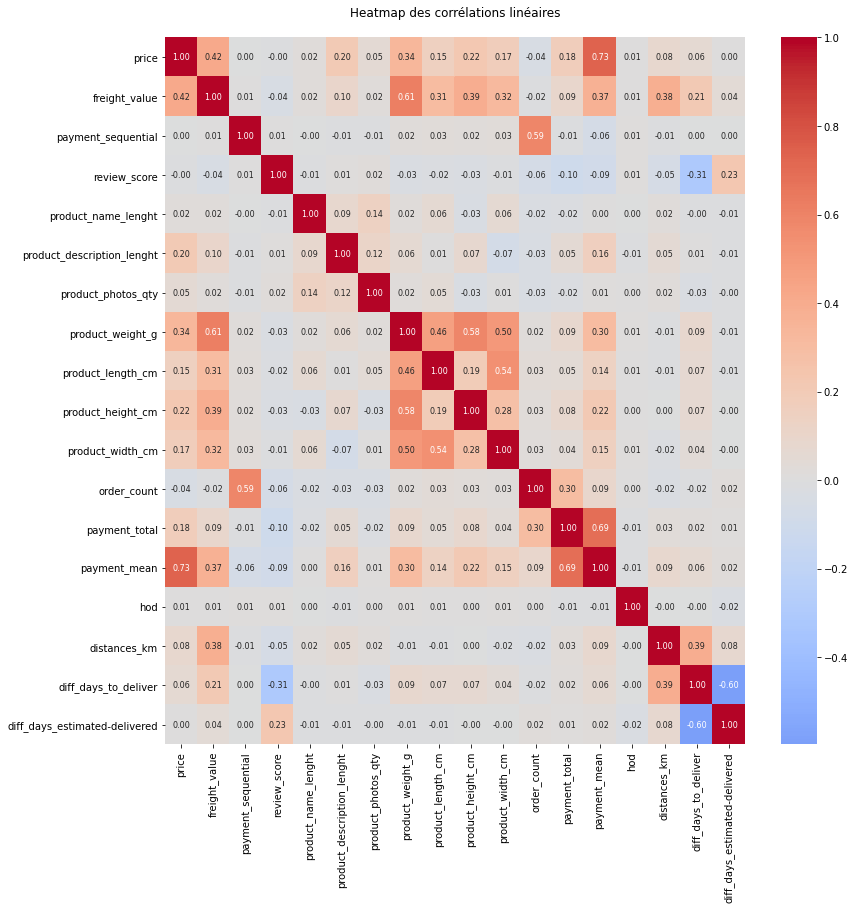

In [175]:
fig, ax = plt.subplots(figsize=(13,13))
ax = sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={'size':8},center=0, cmap="coolwarm")
plt.title(f"Heatmap des corrélations linéaires\n")
plt.show()

Corrélations forte entre:
<font color="green">
- payment_mean et price
- payment_mean et payment_total

- freight_value et product_weight_g
- payment_sequential et order_count

- product_weight_g et product_height_cm
- product_lenght_cm et product_width_cm
</font>

Text(0.5, 0, 'Coefficients de corrélation pour payment_mean')

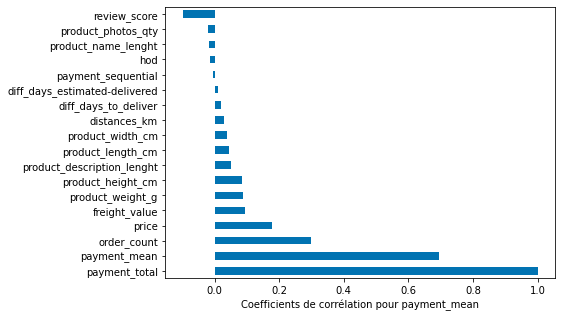

In [176]:
plt.rcParams['figure.figsize'] = (7, 5) 

#correlation with ['payment_total']
numeric_features = data.select_dtypes(include=['float64', 'int64'])
corr = numeric_features.corr()
ax=corr['payment_total'].sort_values(ascending=False).plot(kind="barh")
ax.set_xlabel('Coefficients de corrélation pour payment_mean')

On observe que le `payment_total` est fortement corrélée à `payment_mean` car car ces deux variables dépendent de `payment_value`, donc je supprime `payment_mean` 

In [193]:
#suppression des colonnes non utiles 
data = data.drop(labels=["payment_mean"], axis=1)
data.shape

(114312, 36)

In [178]:
threshold = 0.70
corr = data.corr()
corr_pairs = corr.unstack().sort_values(kind="quicksort")
strong_corr = (pd.DataFrame(corr_pairs[(abs(corr_pairs) > threshold)])
               .reset_index().rename(columns={0:'corr_coeff'}))
strong_corr = strong_corr[(strong_corr.index%2 == 0) & (strong_corr['level_0'] != strong_corr['level_1'])]
strong_corr.sort_values('corr_coeff', ascending=False)

,level_0,level_1,corr_coeff


Il ne reste donc plus de variables corrélées à plus de 0.70.

In [179]:
print(data.shape)
data.head()

(114312, 36)


,product_category_name,product_category_name_english,order_id,product_id,price,freight_value,payment_sequential,payment_type,review_score,review_creation_date,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,most_payment_type,order_count,payment_total,hod,part_day,distances_km,diff_days_to_deliver,diff_days_estimated-delivered
0,beleza_saude,health_beauty,0005a1a1728c9d785b8e2b08b904576c,310ae3c140ff94b03219ad0adc3c778f,145.95,11.65,1.0,credit_card,1,2018-03-30,delivered,2018-03-19 18:40:33,2018-03-29 18:17:31,2018-03-29,59.0,493.0,1.0,2000.0,30.0,12.0,16.0,639d23421f5517f69d0c3d6e6564cf0e,11075,santos,SP,3702,sao paulo,SP,credit_card,1,157.60,18,night,52.44,9.0,-1.0
1,beleza_saude,health_beauty,130aa16eb157e7606fcafbd807c8048e,dfac7527b7d46b412ac29dcabad2f619,113.00,20.28,1.0,credit_card,5,2017-12-14,delivered,2017-12-03 17:28:57,2017-12-13 20:51:50,2017-12-28,38.0,1018.0,1.0,2500.0,35.0,16.0,16.0,742405ae9634962bb67f54214a8247c9,33400,lagoa santa,MG,3702,sao paulo,SP,credit_card,1,133.28,17,afternoon,515.11,10.0,14.0
2,beleza_saude,health_beauty,00d831d5c3ea03b7cd6f883ad799c7e4,eb2d12bc991561d4ca5deff0e60854e4,128.90,9.26,1.0,credit_card,5,2018-03-18,delivered,2018-03-12 11:56:58,2018-03-17 00:52:32,2018-03-26,48.0,333.0,1.0,675.0,23.0,15.0,14.0,b813fe59b2d10fb59d5594ec8f91750e,5716,sao paulo,SP,3702,sao paulo,SP,credit_card,1,138.16,11,morning,22.86,4.0,8.0
3,beleza_saude,health_beauty,00e7aeced1d61792368ec7bf8b967a90,65e3848513c9ab70bf542e5d694cf072,36.85,21.85,1.0,boleto,4,2017-05-05,delivered,2017-04-13 02:11:17,2017-05-04 18:12:45,2017-05-17,46.0,1001.0,1.0,575.0,25.0,13.0,14.0,c76c0ebec1c44b44dca88e42b23149f1,41815,salvador,BA,3702,sao paulo,SP,boleto,1,58.70,2,late_nignt,1447.41,21.0,12.0
4,beleza_saude,health_beauty,01c139e11e826da7bf9782cf1ee904bf,11bbef4e2a44601d9dd471aa1fb433e6,339.99,12.99,1.0,credit_card,4,2017-03-15,delivered,2017-03-05 19:25:45,2017-03-14 09:54:24,2017-03-27,52.0,1222.0,2.0,838.0,28.0,14.0,21.0,c4750b080e135d87328222826982fe39,14460,cristais paulista,SP,3702,sao paulo,SP,credit_card,1,352.98,19,night,357.70,8.0,12.0


Après relecture de la table on peut supprimer ces variables :

In [194]:
#removal of non-useful columns  
list_column = ["review_creation_date", #unuseful
              #'order_purchase_timestamp', #to  keep to select rows bu timestamps
               "order_delivered_customer_date", #because diff_days_to_deliver is created
               "order_estimated_delivery_date", #because diff_days_estimated_delivered is created
               "hod"] #because part_day is created
            

for col in list_column:
    data = data.drop(labels=[col], axis=1)
data.shape

(114312, 32)

In [195]:
#removal of non-useful columns  
list_column = [ "product_weight_g",
              "product_length_cm",
               "product_height_cm",
               "product_width_cm"]
for col in list_column:
    data = data.drop(labels=[col], axis=1)
    
data.shape

(114312, 28)

In [196]:
data.to_csv("2.csv",index=False)

# <font color="#1d479b">Nettoyage</font>

## <font color="#337da4">Doublons</font>

In [4]:
data = pd.read_csv("2.csv")
data.head()

,product_category_name,product_category_name_english,order_id,product_id,price,freight_value,payment_sequential,payment_type,review_score,order_status,order_purchase_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,most_payment_type,order_count,payment_total,part_day,distances_km,diff_days_to_deliver,diff_days_estimated-delivered
0,beleza_saude,health_beauty,0005a1a1728c9d785b8e2b08b904576c,310ae3c140ff94b03219ad0adc3c778f,145.95,11.65,1.0,credit_card,1,delivered,2018-03-19 18:40:33,59.0,493.0,1.0,639d23421f5517f69d0c3d6e6564cf0e,11075,santos,SP,3702,sao paulo,SP,credit_card,1,157.60,night,52.44,9.0,-1.0
1,beleza_saude,health_beauty,130aa16eb157e7606fcafbd807c8048e,dfac7527b7d46b412ac29dcabad2f619,113.00,20.28,1.0,credit_card,5,delivered,2017-12-03 17:28:57,38.0,1018.0,1.0,742405ae9634962bb67f54214a8247c9,33400,lagoa santa,MG,3702,sao paulo,SP,credit_card,1,133.28,afternoon,515.11,10.0,14.0
2,beleza_saude,health_beauty,00d831d5c3ea03b7cd6f883ad799c7e4,eb2d12bc991561d4ca5deff0e60854e4,128.90,9.26,1.0,credit_card,5,delivered,2018-03-12 11:56:58,48.0,333.0,1.0,b813fe59b2d10fb59d5594ec8f91750e,5716,sao paulo,SP,3702,sao paulo,SP,credit_card,1,138.16,morning,22.86,4.0,8.0
3,beleza_saude,health_beauty,00e7aeced1d61792368ec7bf8b967a90,65e3848513c9ab70bf542e5d694cf072,36.85,21.85,1.0,boleto,4,delivered,2017-04-13 02:11:17,46.0,1001.0,1.0,c76c0ebec1c44b44dca88e42b23149f1,41815,salvador,BA,3702,sao paulo,SP,boleto,1,58.70,late_nignt,1447.41,21.0,12.0
4,beleza_saude,health_beauty,01c139e11e826da7bf9782cf1ee904bf,11bbef4e2a44601d9dd471aa1fb433e6,339.99,12.99,1.0,credit_card,4,delivered,2017-03-05 19:25:45,52.0,1222.0,2.0,c4750b080e135d87328222826982fe39,14460,cristais paulista,SP,3702,sao paulo,SP,credit_card,1,352.98,night,357.70,8.0,12.0


In [198]:
#Types
list_column2 = ["customer_zip_code_prefix",
               'seller_zip_code_prefix']
data[list_column2] = data[list_column2].astype('object')

In [199]:
data[data.duplicated(["order_id","product_id", "customer_unique_id"])].sort_values(by="order_id",ascending=True).head(10)

,product_category_name,product_category_name_english,order_id,product_id,price,freight_value,payment_sequential,payment_type,review_score,order_status,order_purchase_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,most_payment_type,order_count,payment_total,part_day,distances_km,diff_days_to_deliver,diff_days_estimated-delivered
21470,ferramentas_jardim,garden_tools,0008288aa423d2a3f00fcb17cd7d8719,368c6c730842d78016ad823897a372db,49.90,13.37,1.0,boleto,5,delivered,2018-02-13 22:10:21,57.0,366.0,2.0,9e4159995424971423b98c4a8bc11529,6600,jandira,SP,15025,sao jose do rio preto,SP,boleto,2,253.08,night,397.49,12.0,7.0
96800,esporte_lazer,sports_leisure,00143d0f86d6fbd9f9b38ab440ac16f5,e95ee6822b66ac6058e2e4aff656071a,21.33,15.10,1.0,credit_card,1,delivered,2017-10-16 15:29:43,52.0,1153.0,1.0,bb8a37225e0279ac8a274c9765617eaf,74663,goiania,GO,18055,sorocaba,SP,credit_card,3,327.87,afternoon,783.07,11.0,9.0
96801,esporte_lazer,sports_leisure,00143d0f86d6fbd9f9b38ab440ac16f5,e95ee6822b66ac6058e2e4aff656071a,21.33,15.10,1.0,credit_card,1,delivered,2017-10-16 15:29:43,52.0,1153.0,1.0,bb8a37225e0279ac8a274c9765617eaf,74663,goiania,GO,18055,sorocaba,SP,credit_card,3,327.87,afternoon,783.07,11.0,9.0
101362,ferramentas_jardim,garden_tools,0016dfedd97fc2950e388d2971d718c7,4089861a1bd4685da70bddd6b4f974f1,49.75,20.80,1.0,credit_card,5,delivered,2017-04-28 19:54:40,44.0,152.0,1.0,33febb33a42a35f5826a22584b127f9d,45860,canavieiras,BA,4041,sao paulo,SP,voucher,2,70.55,night,1193.75,23.0,9.0
63695,eletronicos,electronics,001ab0a7578dd66cd4b0a71f5b6e1e41,0b0172eb0fd18479d29c3bc122c058c2,24.89,17.63,1.0,boleto,4,delivered,2017-12-27 00:38:47,53.0,265.0,2.0,d1f24d1d504e27bee13b415e40daeab0,40055,salvador,BA,72015,brasilia,DF,boleto,3,382.68,late_nignt,1076.68,21.0,11.0
63696,eletronicos,electronics,001ab0a7578dd66cd4b0a71f5b6e1e41,0b0172eb0fd18479d29c3bc122c058c2,24.89,17.63,1.0,boleto,4,delivered,2017-12-27 00:38:47,53.0,265.0,2.0,d1f24d1d504e27bee13b415e40daeab0,40055,salvador,BA,72015,brasilia,DF,boleto,3,382.68,late_nignt,1076.68,21.0,11.0
34978,beleza_saude,health_beauty,001d8f0e34a38c37f7dba2a37d4eba8b,e67307ff0f15ade43fcb6e670be7a74c,18.99,7.78,1.0,credit_card,1,delivered,2017-05-14 17:19:44,47.0,1474.0,3.0,870a0bdc769f9a7870309036740e79ea,2929,sao paulo,SP,1031,sao paulo,SP,credit_card,2,107.08,afternoon,8.99,11.0,-3.0
104025,utilidades_domesticas,housewares,002c9def9c9b951b1bec6d50753c9891,2d9ff06c8870a518f5f6909774e140fb,78.00,8.90,1.0,credit_card,4,delivered,2018-05-14 16:57:47,44.0,543.0,3.0,6bcc1cd0c7f8bffa6f67a6a1fbef5782,1255,sao paulo,SP,7070,guarulhos,SP,credit_card,2,347.60,afternoon,16.66,3.0,6.0
10339,cama_mesa_banho,bed_bath_table,002f19a65a2ddd70a090297872e6d64e,9eae06d51aaa383b2bed5547a19d581c,53.98,23.31,2.0,voucher,3,shipped,2018-03-21 13:05:30,52.0,337.0,1.0,205d5aa158338f2b733a07326aae8c87,42804,camacari,BA,14940,ibitinga,SP,voucher,2,77.29,afternoon,1500.31,NaN,NaN
63031,malas_acessorios,luggage_accessories,003324c70b19a16798817b2b3640e721,2b939dc9b176d7fa21594d588815d4a4,102.90,14.45,1.0,credit_card,1,delivered,2017-05-18 19:04:48,45.0,702.0,1.0,fbe6316a06058c651539cbf59ec5a0ef,39100,diamantina,MG,37564,borda da mata,MG,credit_card,2,469.40,night,521.89,11.0,7.0


In [200]:
#check for one customer
data[data["order_id"]=="00143d0f86d6fbd9f9b38ab440ac16f5"]

,product_category_name,product_category_name_english,order_id,product_id,price,freight_value,payment_sequential,payment_type,review_score,order_status,order_purchase_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,most_payment_type,order_count,payment_total,part_day,distances_km,diff_days_to_deliver,diff_days_estimated-delivered
96799,esporte_lazer,sports_leisure,00143d0f86d6fbd9f9b38ab440ac16f5,e95ee6822b66ac6058e2e4aff656071a,21.33,15.1,1.0,credit_card,1,delivered,2017-10-16 15:29:43,52.0,1153.0,1.0,bb8a37225e0279ac8a274c9765617eaf,74663,goiania,GO,18055,sorocaba,SP,credit_card,3,327.87,afternoon,783.07,11.0,9.0
96800,esporte_lazer,sports_leisure,00143d0f86d6fbd9f9b38ab440ac16f5,e95ee6822b66ac6058e2e4aff656071a,21.33,15.1,1.0,credit_card,1,delivered,2017-10-16 15:29:43,52.0,1153.0,1.0,bb8a37225e0279ac8a274c9765617eaf,74663,goiania,GO,18055,sorocaba,SP,credit_card,3,327.87,afternoon,783.07,11.0,9.0
96801,esporte_lazer,sports_leisure,00143d0f86d6fbd9f9b38ab440ac16f5,e95ee6822b66ac6058e2e4aff656071a,21.33,15.1,1.0,credit_card,1,delivered,2017-10-16 15:29:43,52.0,1153.0,1.0,bb8a37225e0279ac8a274c9765617eaf,74663,goiania,GO,18055,sorocaba,SP,credit_card,3,327.87,afternoon,783.07,11.0,9.0


In [201]:
data.duplicated(["order_id","product_id", "customer_unique_id"]).sum()

15285

In [202]:
data = data.drop_duplicates(["order_id","product_id", "customer_unique_id"],keep = 'first')
print(data.shape)

(99027, 28)


## <font color="#337da4">Outliers</font>

Le terme anglophone d'**outlier** peut désigner deux choses en français : une valeur atypique ou une valeur aberrante.


**Donnée atypique** : "Des valeurs extrêmes, qui reflètent la réalité "inhabituelle". Il convient d'en tenir compte mais elles ont leur place dans la base de données. Il ne faut pas les confondre avec les **valeurs aberrantes**, qui sont fausses et qu'il faut traiter." 

http://www.jybaudot.fr/Stats/outliers.html

**Donnée aberrante**: "Les données aberrantes peuvent apparaître par hasard dans n'importe quelle distribution, mais elles indiquent souvent 

- soit une **erreur de mesure - "erreur expérimentale"** :  il convient de se débarrasser de ces valeurs ou bien d'utiliser des indicateurs statistiques plus robustes face aux données aberrantes par exemple, favoriser la médiane plutôt que la moyenne.

- soit que la **population est distribuée suivant une loi de probabilité à queue lourde** : la distribution est fortement asymétrique et qu'il faut donc se montrer très prudent dans l'utilisation d'outils ou de raisonnement conçus pour une distribution normale.

https://fr.wikipedia.org/wiki/Donn%C3%A9e_aberrante


In [203]:
numeric_features = data.select_dtypes(include=['int64','float64'])#df
X = numeric_features[numeric_features.columns].values #array
X.shape[1] #colonnes

12

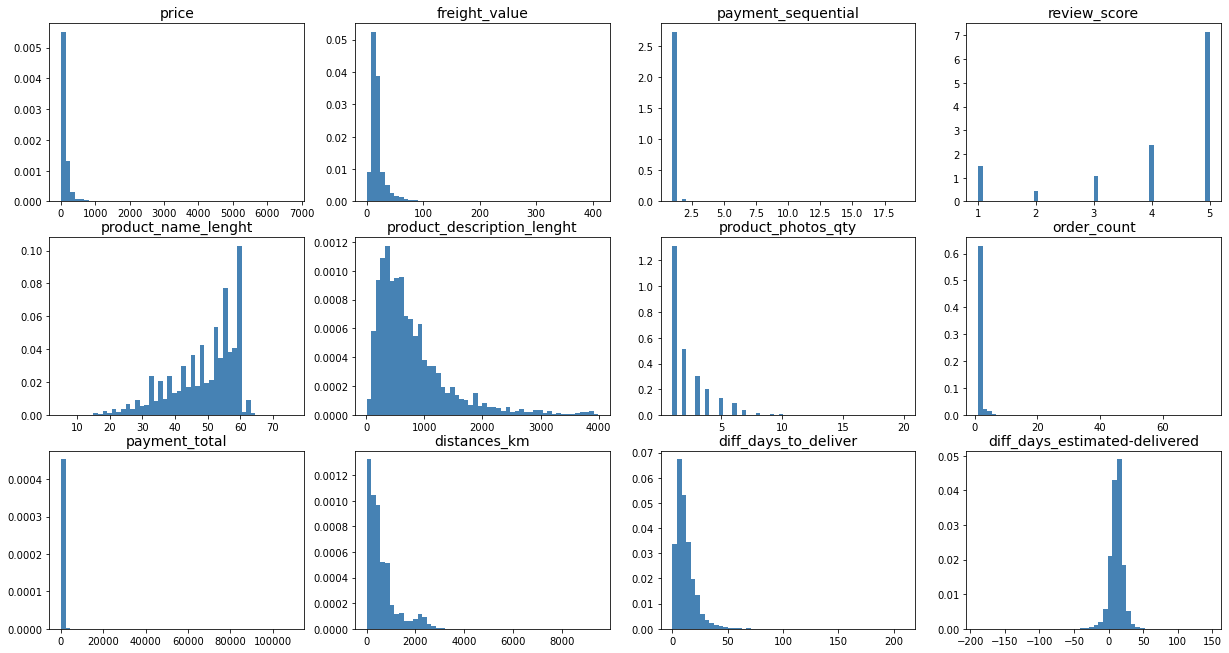

In [204]:
fig = plt.figure(figsize=(21, 19))

for feat_idx in range(X.shape[1]):
    ax = fig.add_subplot(5,4, (feat_idx+1))
    h = ax.hist(X[:, feat_idx], bins=50, color='steelblue', density=True, edgecolor='none')  
    ax.set_title(numeric_features.columns[feat_idx], fontsize=14)

Nous allons centrer et réduire pour avoir le même ordre de grandeur.

In [205]:
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(X)
X_std = std_scale.transform(X)

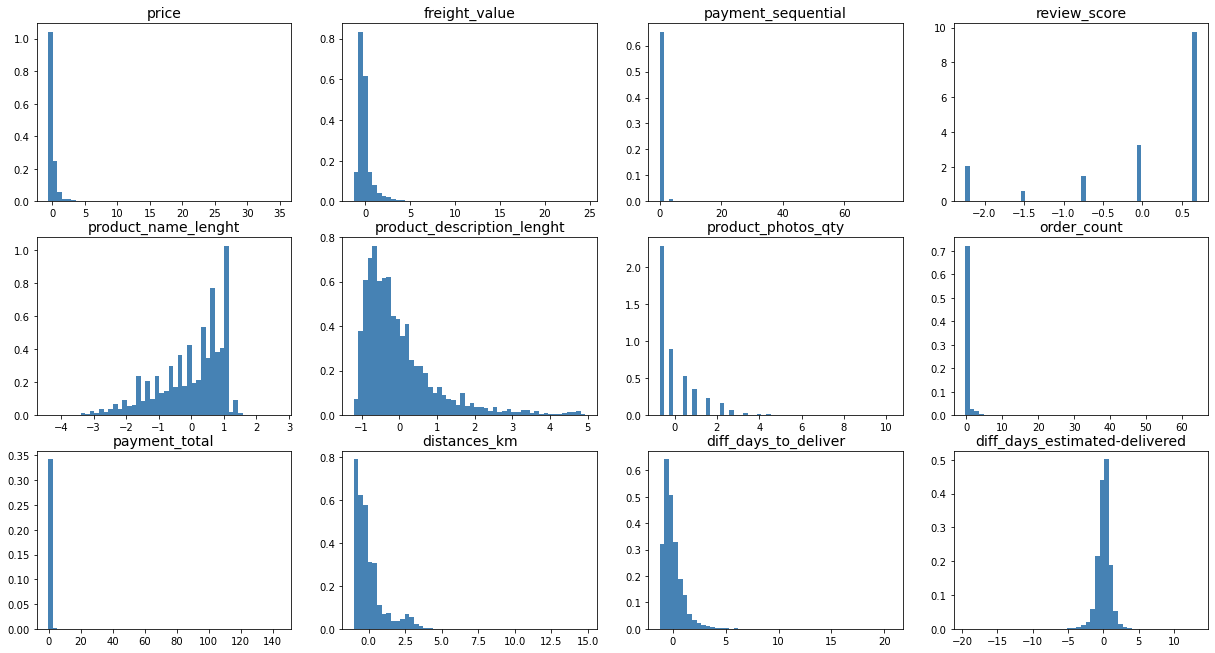

In [206]:
fig = plt.figure(figsize=(21, 19))

for feat_idx in range(X_std.shape[1]):
    ax = fig.add_subplot(5,4, (feat_idx+1))
    h = ax.hist(X_std[:, feat_idx], bins=50, color='steelblue', density=True, edgecolor='none')
    ax.set_title(numeric_features.columns[feat_idx], fontsize=14)

Présence de queue épaisse pour la variable `distances_km`,`product_name_lenght`, `product_description_lenght`. Donc pour ces variables, faire attention à ne pas appliquer la loi normale. Nous allons conserver ces valeurs extrêmes. 

Par contre, vérifions si il y a des **valeurs aberrantes** s'agissant d'erreurs:

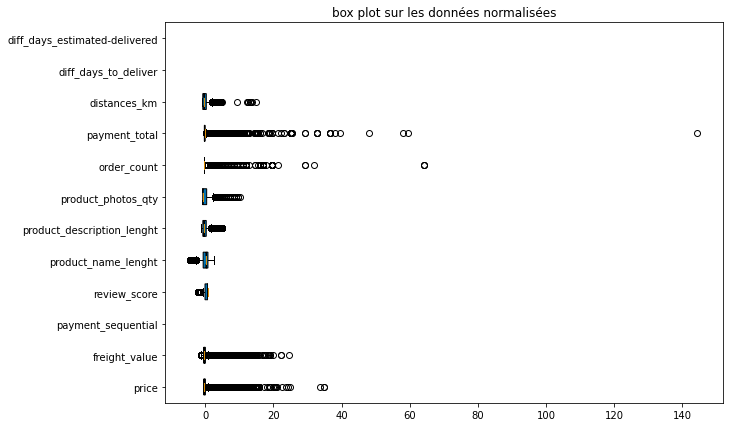

In [207]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
 
# Creating axes instance
bp = ax.boxplot(X_std, patch_artist = True, notch ='True', vert = 0)
ax.set_yticklabels(list(numeric_features.columns))
plt.title("box plot sur les données normalisées")
# show plot
plt.show(bp)


On observe une valeur très éloignée pour la variable **`payment_total`**. Voyons à quoi cela correspond.

In [208]:
data[data['payment_total']==data['payment_total'].max()]

,product_category_name,product_category_name_english,order_id,product_id,price,freight_value,payment_sequential,payment_type,review_score,order_status,order_purchase_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,most_payment_type,order_count,payment_total,part_day,distances_km,diff_days_to_deliver,diff_days_estimated-delivered
109991,telefonia_fixa,fixed_telephony,03caa2c082116e1d31e67e9ae3700499,5769ef0a239114ac3a854af00df129e4,1680.0,28.01,1.0,credit_card,1,delivered,2017-09-29 15:24:52,39.0,2493.0,3.0,0a0a92112bd4c708ca5fde585afaa872,20080,rio de janeiro,RJ,3667,sao paulo,SP,credit_card,8,109312.64,afternoon,345.87,18.0,5.0


Voyons ce que ce client a commandé :

In [209]:
data[data['customer_unique_id']=="0a0a92112bd4c708ca5fde585afaa872"]

,product_category_name,product_category_name_english,order_id,product_id,price,freight_value,payment_sequential,payment_type,review_score,order_status,order_purchase_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,most_payment_type,order_count,payment_total,part_day,distances_km,diff_days_to_deliver,diff_days_estimated-delivered
109991,telefonia_fixa,fixed_telephony,03caa2c082116e1d31e67e9ae3700499,5769ef0a239114ac3a854af00df129e4,1680.0,28.01,1.0,credit_card,1,delivered,2017-09-29 15:24:52,39.0,2493.0,3.0,0a0a92112bd4c708ca5fde585afaa872,20080,rio de janeiro,RJ,3667,sao paulo,SP,credit_card,8,109312.64,afternoon,345.87,18.0,5.0


Il s'agit d'une **valeur atypique** donc on va la conserver. 


Et le [`price`+ `freight_value` ] * 8 =  13 664,08.


Et il a passé 8 commandes d'une valeur de 13 664,08 Réal  = 109312.64 (17 720,26 euros). 

In [210]:
data.describe()

,price,freight_value,payment_sequential,review_score,product_name_lenght,product_description_lenght,product_photos_qty,order_count,payment_total,distances_km,diff_days_to_deliver,diff_days_estimated-delivered
count,99027.00,99027.00,99026.00,99027.00,99027.00,99027.00,99027.00,99027.00,99027.00,99027.00,96905.00,96905.00
mean,124.67,20.13,1.02,4.06,48.88,786.99,2.23,1.37,249.18,601.64,12.03,11.00
std,188.95,15.90,0.24,1.36,9.99,649.10,1.74,1.15,755.32,597.59,9.54,10.23
min,0.85,0.00,1.00,1.00,5.00,4.00,1.00,1.00,0.00,0.00,0.00,-189.00
25%,40.35,13.12,1.00,4.00,43.00,348.00,1.00,1.00,66.38,187.25,6.00,6.00
50%,78.50,16.33,1.00,5.00,52.00,603.00,1.00,1.00,120.04,434.08,10.00,12.00
75%,139.00,21.26,1.00,5.00,57.00,989.00,3.00,1.00,227.06,798.30,15.00,16.00
max,6735.00,409.68,19.00,5.00,76.00,3992.00,20.00,75.00,109312.64,9475.60,209.00,146.00


In [211]:
data[data['diff_days_estimated-delivered']==-189.00]

,product_category_name,product_category_name_english,order_id,product_id,price,freight_value,payment_sequential,payment_type,review_score,order_status,order_purchase_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,most_payment_type,order_count,payment_total,part_day,distances_km,diff_days_to_deliver,diff_days_estimated-delivered
23862,cool_stuff,cool_stuff,1b3190b2dfa9d789e1f14c05b647a14a,ee406bf28024d97771c4b1e8b7e8e219,144.99,17.26,1.0,credit_card,2,delivered,2018-02-23 14:57:35,54.0,629.0,1.0,eb21169c3153a2b507fc7e76d561ff14,22723,rio de janeiro,RJ,3426,sao paulo,SP,credit_card,1,162.25,afternoon,326.94,208.0,-189.0


Il existe des délais en jours proche de 200 jours. Il peut s'agir de **valeurs atypiques** pouvant concerner des produits non disponibles.

Analysons le reste des variables quantitatives :

In [212]:
data.describe()

,price,freight_value,payment_sequential,review_score,product_name_lenght,product_description_lenght,product_photos_qty,order_count,payment_total,distances_km,diff_days_to_deliver,diff_days_estimated-delivered
count,99027.00,99027.00,99026.00,99027.00,99027.00,99027.00,99027.00,99027.00,99027.00,99027.00,96905.00,96905.00
mean,124.67,20.13,1.02,4.06,48.88,786.99,2.23,1.37,249.18,601.64,12.03,11.00
std,188.95,15.90,0.24,1.36,9.99,649.10,1.74,1.15,755.32,597.59,9.54,10.23
min,0.85,0.00,1.00,1.00,5.00,4.00,1.00,1.00,0.00,0.00,0.00,-189.00
25%,40.35,13.12,1.00,4.00,43.00,348.00,1.00,1.00,66.38,187.25,6.00,6.00
50%,78.50,16.33,1.00,5.00,52.00,603.00,1.00,1.00,120.04,434.08,10.00,12.00
75%,139.00,21.26,1.00,5.00,57.00,989.00,3.00,1.00,227.06,798.30,15.00,16.00
max,6735.00,409.68,19.00,5.00,76.00,3992.00,20.00,75.00,109312.64,9475.60,209.00,146.00


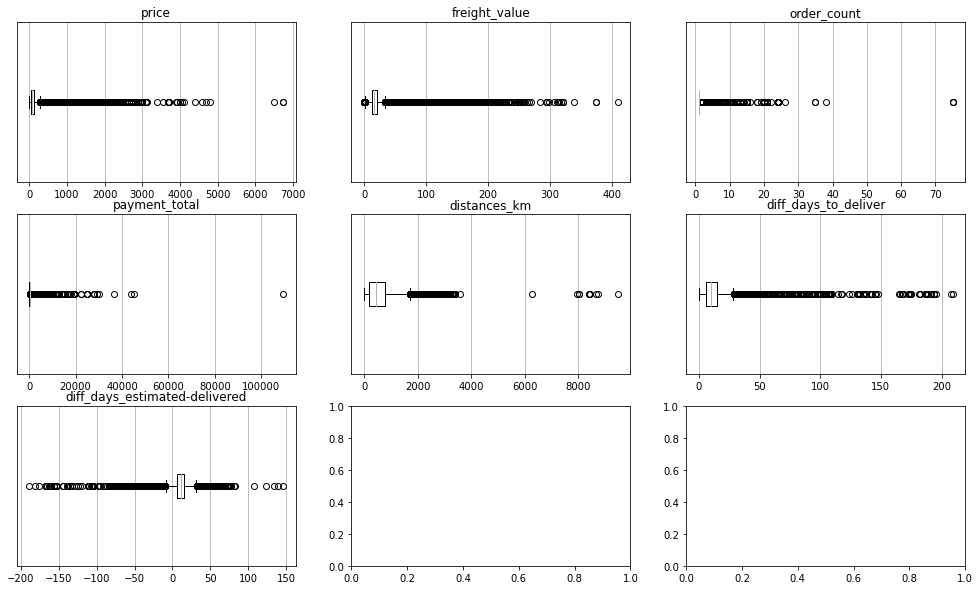

<Figure size 1224x720 with 0 Axes>

In [213]:
plt.rcParams['figure.figsize'] = (17, 10)
figure, axes = plt.subplots(3, 3)

#Observation avant suppression 
ax1 = data[["price"]].boxplot(ax=axes[0,0],column="price", vert=False)
ax1.set_title("price")
ax2 = data[["freight_value"]].boxplot(ax=axes[0,1],column="freight_value", vert=False)
ax2.set_title("freight_value")
ax3 = data[["order_count"]].boxplot(ax=axes[0,2],column="order_count", vert=False)
ax3.set_title("order_count")
ax4 = data[["payment_total"]].boxplot(ax=axes[1,0],column="payment_total",vert=False)
ax4.set_title("payment_total")

ax5 = data[["distances_km"]].boxplot(ax=axes[1,1],column="distances_km", vert=False)
ax5.set_title("distances_km")
ax6= data[["diff_days_to_deliver"]].boxplot(ax=axes[1,2],column="diff_days_to_deliver", vert=False)
ax6.set_title("diff_days_to_deliver")
ax7= data[["diff_days_estimated-delivered"]].boxplot(ax=axes[2,0],column="diff_days_estimated-delivered", vert=False)
ax7.set_title("diff_days_estimated-delivered")

for axes in (ax1, ax2, ax3,ax4,ax5,ax6,ax7):
    axes.yaxis.set_visible(False)

plt.figure();

Vérifions les données:

In [214]:
data[data["price"]==data['price'].max()]

,product_category_name,product_category_name_english,order_id,product_id,price,freight_value,payment_sequential,payment_type,review_score,order_status,order_purchase_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,most_payment_type,order_count,payment_total,part_day,distances_km,diff_days_to_deliver,diff_days_estimated-delivered
113794,utilidades_domesticas,housewares,0812eb902a67711a1cb742b3cdaa65ae,489ae2aa008f021502940f251d4cce7f,6735.0,194.31,1.0,credit_card,5,delivered,2017-02-12 20:37:36,31.0,875.0,2.0,dc4802a71eae9be1dd28f5d788ceb526,79042,campo grande,MS,3635,sao paulo,SP,credit_card,1,6929.31,night,893.47,18.0,5.0


In [215]:
data[data["freight_value"]==data['freight_value'].max()]

,product_category_name,product_category_name_english,order_id,product_id,price,freight_value,payment_sequential,payment_type,review_score,order_status,order_purchase_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,most_payment_type,order_count,payment_total,part_day,distances_km,diff_days_to_deliver,diff_days_estimated-delivered
108477,bebes,baby,a77e1550db865202c56b19ddc6dc4d53,ec31d2a17b299511e7c8627be9337b9b,979.0,409.68,1.0,credit_card,5,delivered,2018-04-16 14:57:21,44.0,385.0,6.0,97734fdca127fddcb5f92f841690c3f2,64770,sao raimundo nonato,PI,86804,apucarana,PR,credit_card,1,1388.68,afternoon,1864.73,11.0,19.0


In [216]:
data[data["order_count"]==data['order_count'].max()] # 3 orders 75 times

,product_category_name,product_category_name_english,order_id,product_id,price,freight_value,payment_sequential,payment_type,review_score,order_status,order_purchase_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,most_payment_type,order_count,payment_total,part_day,distances_km,diff_days_to_deliver,diff_days_estimated-delivered
52264,moveis_decoracao,furniture_decor,67d83bd36ec2c7fb557742fb58837659,4eb99b5f0d7e411f246a5c9c0ae27a5e,45.20,26.97,7.0,voucher,5,delivered,2017-07-27 12:50:46,63.0,330.0,1.0,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,13920,pedreira,SP,voucher,75,556.13,morning,99.75,5.0,14.0
82425,cama_mesa_banho,bed_bath_table,895ab968e7bb0d5659d16cd74cd1650c,ebf9bc6cd600eadd681384e3116fda85,12.99,23.21,17.0,voucher,5,delivered,2017-08-08 20:26:31,37.0,86.0,2.0,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,25803,tres rios,RJ,voucher,75,556.13,night,381.57,5.0,15.0
110951,utilidades_domesticas,housewares,895ab968e7bb0d5659d16cd74cd1650c,5ddab10d5e0a23acb99acf56b62b3276,83.80,5.12,17.0,voucher,5,delivered,2017-08-08 20:26:31,56.0,548.0,8.0,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,89217,joinville,SC,voucher,75,556.13,night,379.49,5.0,15.0


**<font color="green">Au final, ce sont des valeurs atypiques que nous pouvons conserver. Il n'y a pas de valeurs aberrantes.</font>**

# <font color="#1d479b">Analyse exploratoire des données</font>

## <font color="#337da4">Analyse univariée - variables catégoriques</font>

In [217]:
categorical_features = data.select_dtypes(exclude=['int64','float64']) 
categorical_features.describe(include="object").transpose()

,count,unique,top,freq
product_category_name,99027,71,cama_mesa_banho,10058
product_category_name_english,99027,71,bed_bath_table,10058
order_id,99027,95403,ca3625898fbd48669d50701aba51cd5f,8
product_id,99027,31701,99a4788cb24856965c36a24e339b6058,466
payment_type,99026,4,credit_card,75243
order_status,99027,7,delivered,96906
order_purchase_timestamp,99027,94884,2018-08-12 02:11:20,8
customer_unique_id,99027,92340,8d50f5eadf50201ccdcedfb9e2ac8455,15
customer_zip_code_prefix,99027,14709,22790,138
customer_city,99027,4017,sao paulo,15551


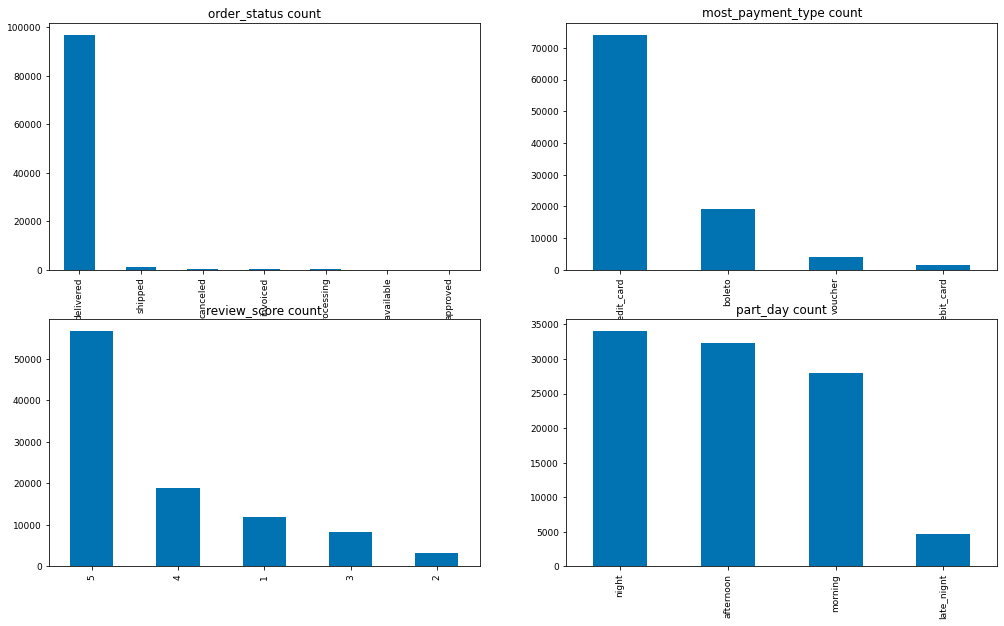

<Figure size 1800x1440 with 0 Axes>

In [218]:
fig, axes = plt.subplots(nrows=2, ncols=2)
plt.rcParams['figure.figsize'] = (25,20) 


ax0=data["order_status"].value_counts(normalize=False).plot(ax=axes[0,0],kind='bar',fontsize=9)
ax1=data["most_payment_type"].value_counts(normalize=False).plot(ax=axes[0,1],kind='bar',fontsize=9)
ax2=data["review_score"].value_counts(normalize=False).plot(ax=axes[1,0],kind='bar',fontsize=9)
ax3=data["part_day"].value_counts(normalize=False).plot(ax=axes[1,1],kind='bar',fontsize=9)

ax0.set_title("order_status count")
ax1.set_title("most_payment_type count")
ax2.set_title("review_score count")
ax3.set_title("part_day count")

plt.figure();

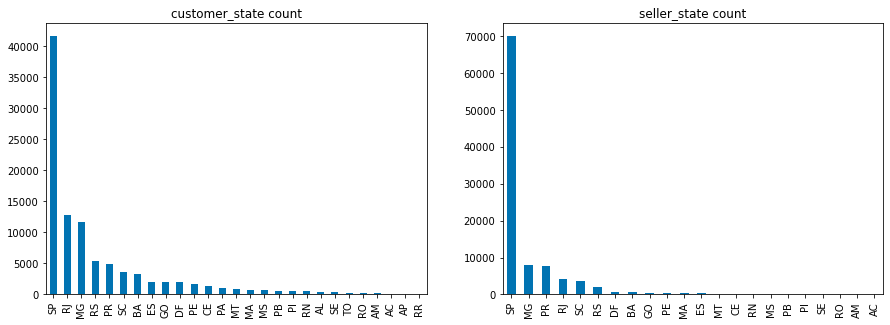

<Figure size 1080x360 with 0 Axes>

In [219]:
plt.rcParams['figure.figsize'] = (15,5)  
fig, axes = plt.subplots(nrows=1, ncols=2)

ax2=data["customer_state"].value_counts(normalize=False).plot(ax=axes[0],kind='bar')
ax3=data["seller_state"].value_counts(normalize=False).plot(ax=axes[1],kind='bar')
ax2.set_title("customer_state count")
ax3.set_title("seller_state count")
plt.figure();

Pour les noms des Etats :https://brazil-help.com/brazilian_states.htm

On voit que l'Etat principal est **Sao Paulo** est largement en tête tant pour les clients que pour les vendeurs.

In [220]:
data.product_category_name_english.nunique()

71

Text(0.5, 1.0, 'Product Category Count')

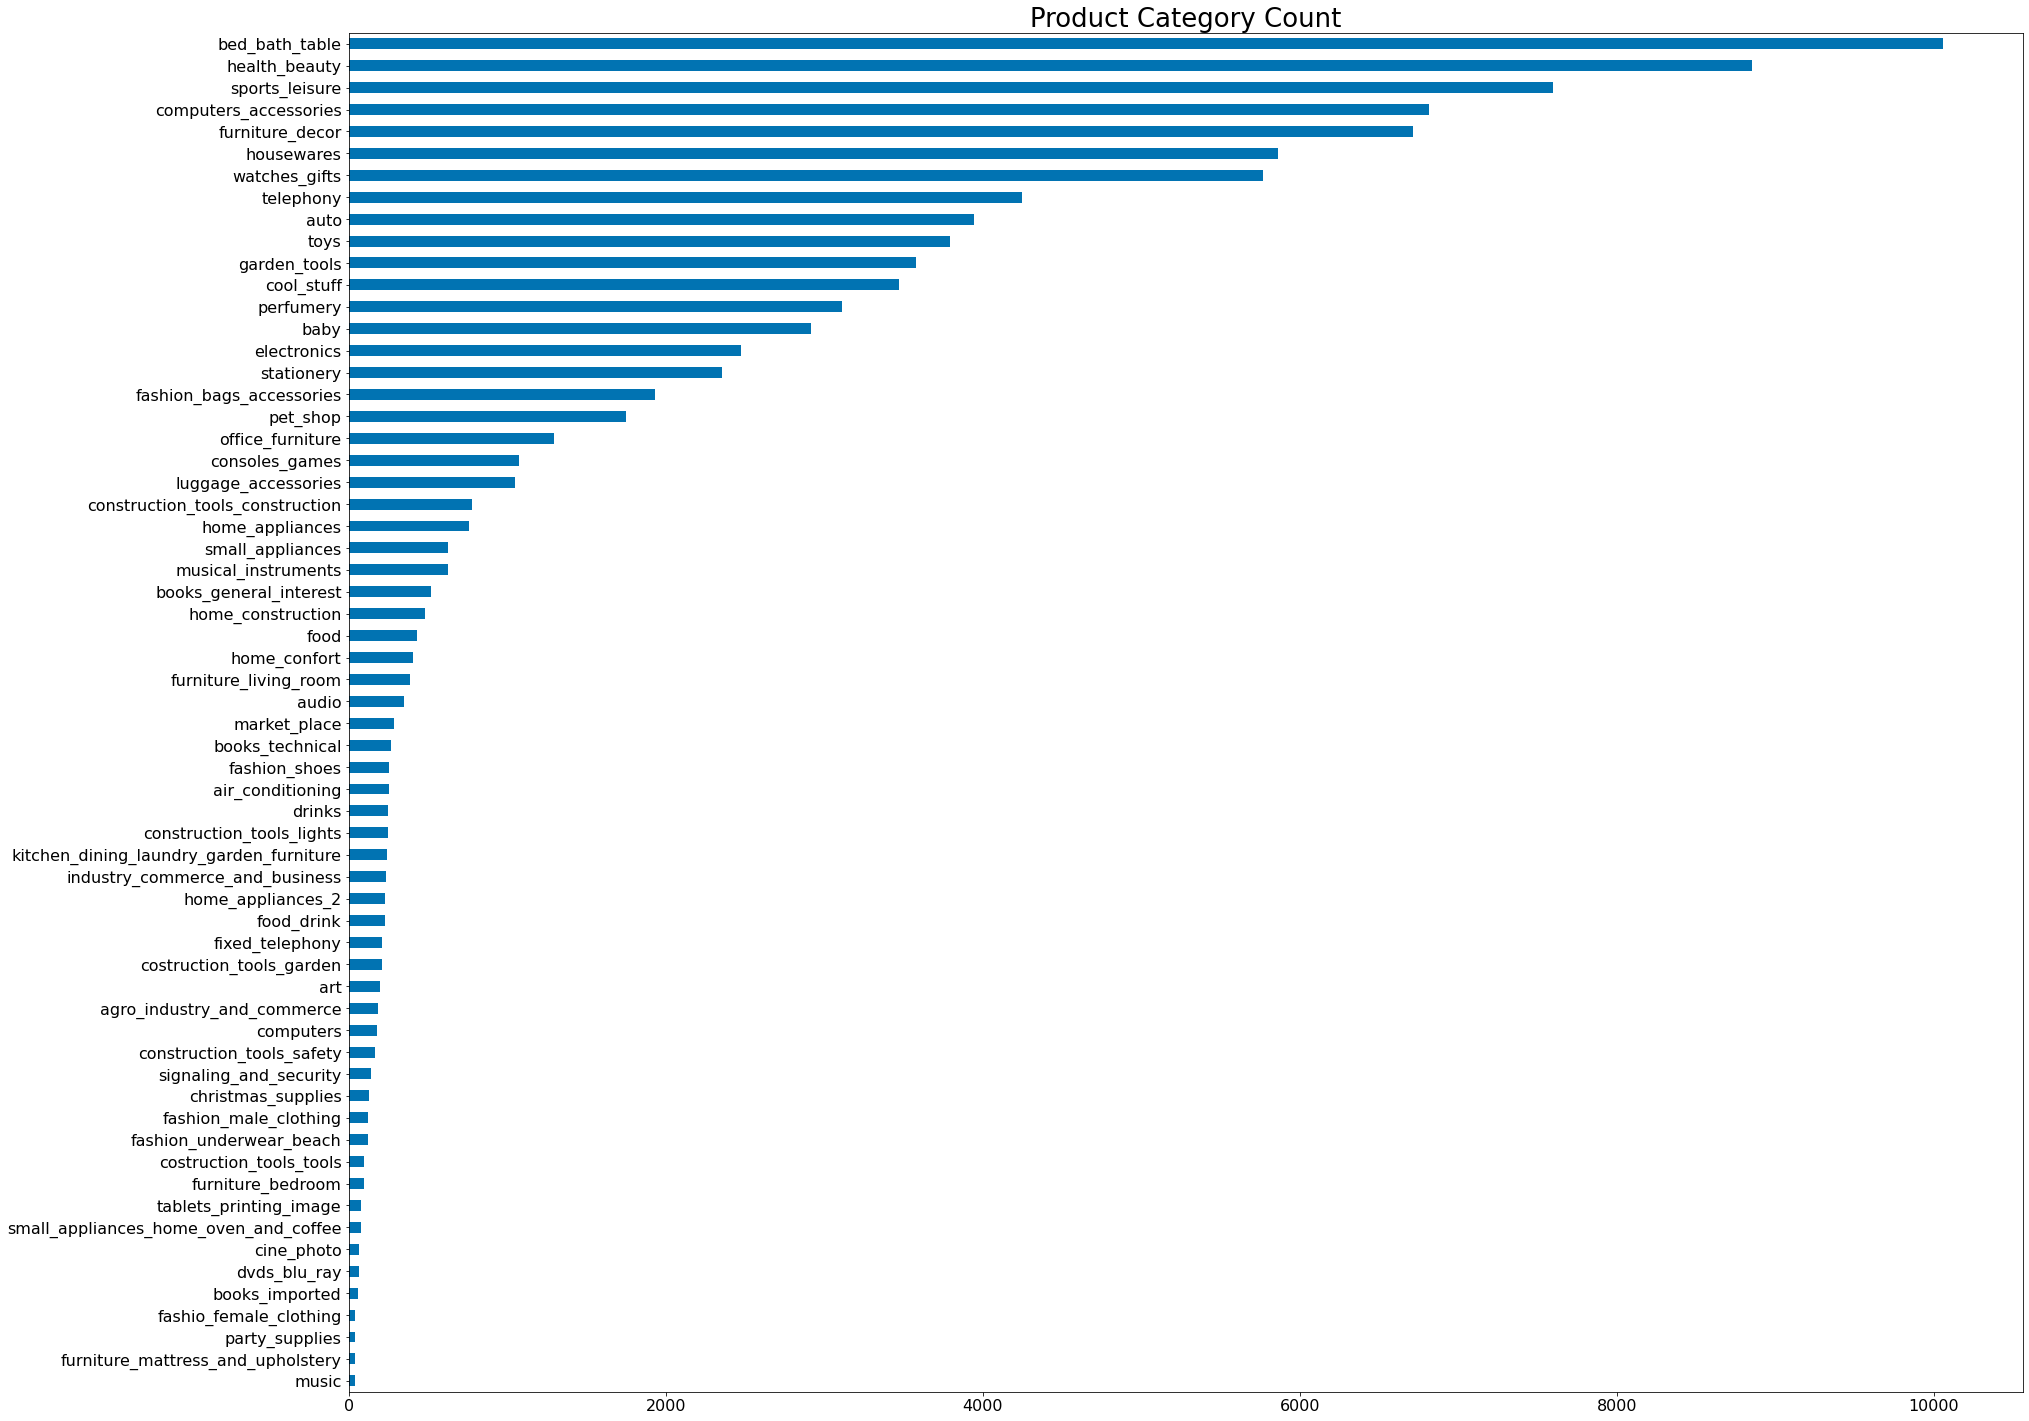

In [221]:
plt.rcParams['figure.figsize'] = (30,25) #(L,l)

data["product_category_name_english"].value_counts(normalize=False).sort_values(ascending=True).iloc[9:,].plot(kind='barh',fontsize = 16)

plt.title("Product Category Count", fontsize = 26)

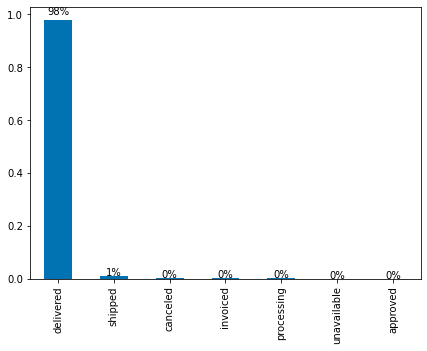

In [222]:
plt.rcParams['figure.figsize'] = (7,5) 

ax = data["order_status"].value_counts(normalize=True).plot(kind='bar')

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.0%}', (x + width/2, y + height*1.02), ha='center')
    
plt.show()

## <font color="#337da4">Analyse univariée - variables quantitatives</font>

In [223]:
data.describe()

,price,freight_value,payment_sequential,review_score,product_name_lenght,product_description_lenght,product_photos_qty,order_count,payment_total,distances_km,diff_days_to_deliver,diff_days_estimated-delivered
count,99027.00,99027.00,99026.00,99027.00,99027.00,99027.00,99027.00,99027.00,99027.00,99027.00,96905.00,96905.00
mean,124.67,20.13,1.02,4.06,48.88,786.99,2.23,1.37,249.18,601.64,12.03,11.00
std,188.95,15.90,0.24,1.36,9.99,649.10,1.74,1.15,755.32,597.59,9.54,10.23
min,0.85,0.00,1.00,1.00,5.00,4.00,1.00,1.00,0.00,0.00,0.00,-189.00
25%,40.35,13.12,1.00,4.00,43.00,348.00,1.00,1.00,66.38,187.25,6.00,6.00
50%,78.50,16.33,1.00,5.00,52.00,603.00,1.00,1.00,120.04,434.08,10.00,12.00
75%,139.00,21.26,1.00,5.00,57.00,989.00,3.00,1.00,227.06,798.30,15.00,16.00
max,6735.00,409.68,19.00,5.00,76.00,3992.00,20.00,75.00,109312.64,9475.60,209.00,146.00


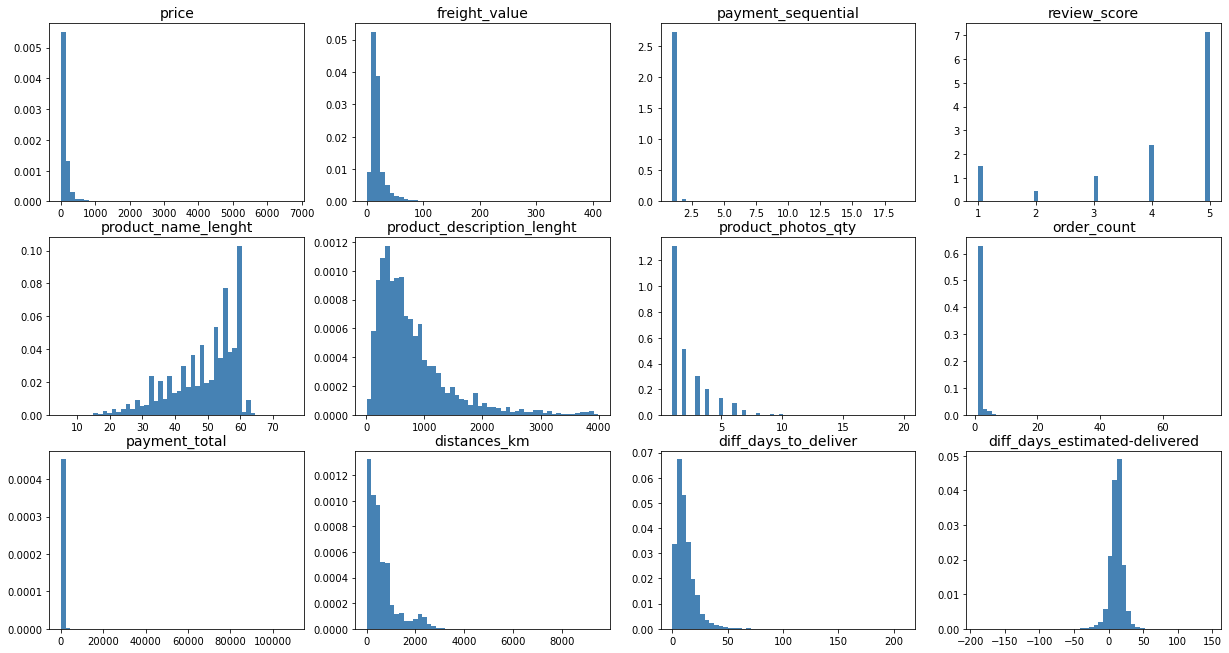

In [224]:
fig = plt.figure(figsize=(21, 19))

numeric_features = data.select_dtypes(include=['int64','float64'])#df
X = numeric_features[numeric_features.columns].values #array

for feat_idx in range(X.shape[1]):
    ax = fig.add_subplot(5,4, (feat_idx+1))
    h = ax.hist(X[:, feat_idx], bins=50, color='steelblue', density=True, edgecolor='none')  
    ax.set_title(numeric_features.columns[feat_idx], fontsize=14)

Text(0.5, 1.0, "Fréquence du nombre d'achat par client")

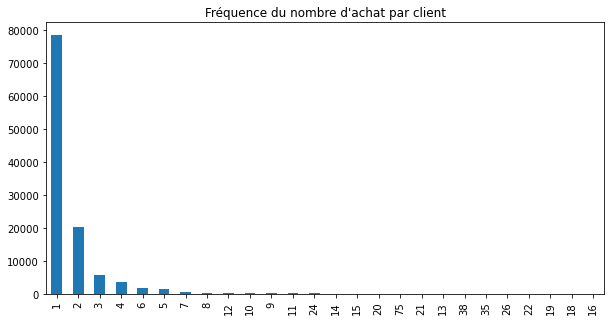

In [5]:
data.order_count.value_counts().plot(kind='bar')
plt.title("Fréquence du nombre d'achat par client")

Il extsite majoritairement des `order_count = 1`. Cela n'est peut-être pas représentatif de la population globale. Il serait intéressant d'enrichir les lignes pour cette colonne.

## <font color="#337da4">Analyse bi-variée entre 2 variables quantitatives</font>

Text(0.5, 0, 'Coefficients de corrélation pour payment_total')

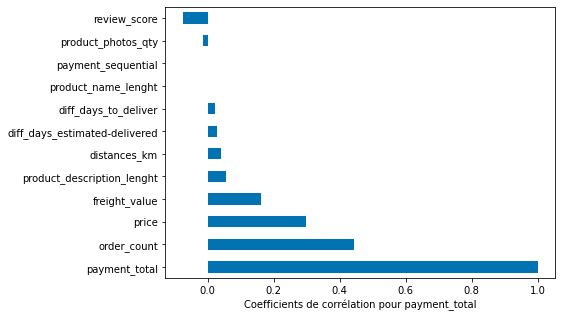

In [228]:
plt.rcParams['figure.figsize'] = (7, 5) 

numeric_features = data.select_dtypes(include=['float64', 'int64'])
corr = numeric_features.corr()

ax=corr['payment_total'].sort_values(ascending=False).plot(kind="barh")
ax.set_xlabel('Coefficients de corrélation pour payment_total')

In [229]:
ax=corr['payment_total'].sort_values(ascending=False)
ax

payment_total                    1.00e+00
order_count                      4.42e-01
price                            2.98e-01
freight_value                    1.61e-01
product_description_lenght       5.51e-02
distances_km                     4.06e-02
diff_days_estimated-delivered    2.80e-02
diff_days_to_deliver             2.09e-02
product_name_lenght              1.45e-03
payment_sequential              -1.87e-04
product_photos_qty              -1.46e-02
review_score                    -7.59e-02
Name: payment_total, dtype: float64

## <font color="#337da4">Analyse bi-variée entre variables quantitatives et catégoriques</font>

In [230]:
categorical_features = data.select_dtypes(exclude=['int64','float64']) 
categorical_features.describe(include="object").transpose()

,count,unique,top,freq
product_category_name,99027,71,cama_mesa_banho,10058
product_category_name_english,99027,71,bed_bath_table,10058
order_id,99027,95403,ca3625898fbd48669d50701aba51cd5f,8
product_id,99027,31701,99a4788cb24856965c36a24e339b6058,466
payment_type,99026,4,credit_card,75243
order_status,99027,7,delivered,96906
order_purchase_timestamp,99027,94884,2018-08-12 02:11:20,8
customer_unique_id,99027,92340,8d50f5eadf50201ccdcedfb9e2ac8455,15
customer_zip_code_prefix,99027,14709,22790,138
customer_city,99027,4017,sao paulo,15551


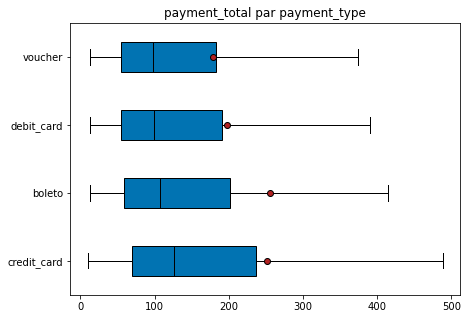

In [231]:
sns.set_palette(sns.color_palette("colorblind", 3))

X = "payment_type" # qualitative
Y = "payment_total" # quantitative
sous_echantillon = data[data["payment_total"] > 0].copy()
modalites = sous_echantillon[X].unique()
groupes = []

for m in modalites:
    groupes.append(sous_echantillon[sous_echantillon[X]==m][Y])
    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'} #la moyenne des valeurs.
    
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.title("payment_total par payment_type")
plt.show()

In [232]:
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT     #variation interclasse / variation totale

In [233]:
X = "payment_type" # qual
Y = "payment_total" # quant
eta_squared(sous_echantillon[X],sous_echantillon[Y]) #[0,1]

0.00032600239340631267

Le modèle explique 0,003% de la variation entre les valeurs y_pred et y_test. \
**Les deux variables `payment_type`et `payment_total` ne sont pas corrélées** même si on observe **une tendance favorable pour les paiements par carte.**

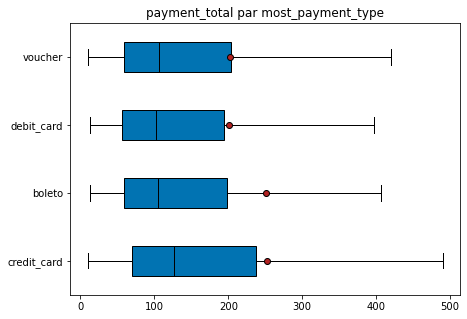

In [234]:
# Changement de la palette graphique
sns.set_palette(sns.color_palette("colorblind", 3))

X = "most_payment_type" # qualitative
Y = "payment_total" # quantitative
sous_echantillon = data[data["payment_total"] > 0].copy()
modalites = sous_echantillon[X].unique()
groupes = []

for m in modalites:
    groupes.append(sous_echantillon[sous_echantillon[X]==m][Y])
    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'} #la moyenne des valeurs.
    
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.title("payment_total par most_payment_type")
plt.show()

In [235]:
X = "most_payment_type" # qualitative
Y = "payment_total" # quantitative
eta_squared(sous_echantillon[X],sous_echantillon[Y]) #[0,1]

0.000229330319896904

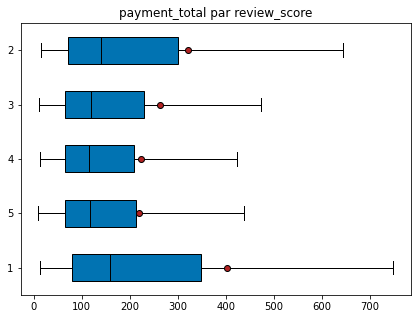

In [236]:
# Changement de la palette graphique
sns.set_palette(sns.color_palette("colorblind", 3))

X = "review_score" # qualitative
Y = "payment_total" # quantitative
sous_echantillon = data[data["payment_total"] > 0].copy()
modalites = sous_echantillon[X].unique()
groupes = []

for m in modalites:
    groupes.append(sous_echantillon[sous_echantillon[X]==m][Y])
    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'} #la moyenne des valeurs.
    
ax1 = plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.title("payment_total par review_score")

plt.show()

In [237]:
X = "review_score" # qualitative
Y = "payment_total" # quantitative

sous_echantillon = data[data["payment_total"] >0]
eta_squared(sous_echantillon[X],sous_echantillon[Y]) #[0,1]

0.006406503914152806

Le modèle explique 0,64% de la variation entre les valeurs y_pred et y_test. 

**Plus la valeur du panier total est élevée plus la note est faible et vice versa.**

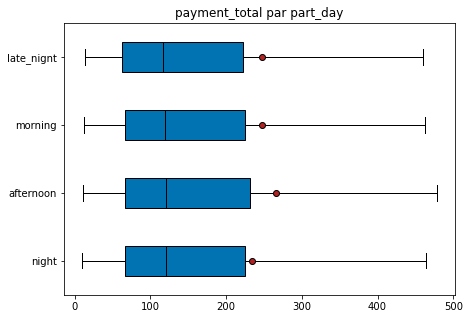

In [238]:
# Changement de la palette graphique
sns.set_palette(sns.color_palette("colorblind", 3))

X = "part_day" # qualitative
Y = "payment_total" # quantitative
sous_echantillon = data[data["payment_total"] > 0].copy()
modalites = sous_echantillon[X].unique()
groupes = []

for m in modalites:
    groupes.append(sous_echantillon[sous_echantillon[X]==m][Y])
    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'} #la moyenne des valeurs.
    
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.title("payment_total par part_day")

plt.show()

In [239]:
X = "part_day" # qualitative
Y = "payment_total" # quantitative

# On ne garde que les dépenses
sous_echantillon = data[data["payment_total"] >0]
eta_squared(sous_echantillon[X],sous_echantillon[Y]) #[0,1]

0.0003059636977579062

Le modèle explique 0,03% de la variation entre les valeurs y_pred et y_test. On remarque que **même si peu de transaction se font tard la nuit, ils représentent tout de même une part équivalentes aux autres parties de la journée**.

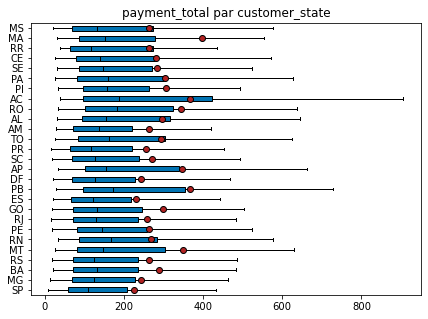

In [240]:
# Changement de la palette graphique
sns.set_palette(sns.color_palette("colorblind", 3))

X = "customer_state" # qualitative
Y = "payment_total" # quantitative
sous_echantillon = data[data["payment_total"] > 0].copy()
modalites = sous_echantillon[X].unique()
groupes = []

for m in modalites:
    groupes.append(sous_echantillon[sous_echantillon[X]==m][Y])
    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'} #la moyenne des valeurs.
    
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.title("payment_total par customer_state")

plt.show()

In [241]:
X = "customer_state" # qualitative
Y = "payment_total" # quantitative

sous_echantillon = data[data["payment_total"] >0]
eta_squared(sous_echantillon[X],sous_echantillon[Y]) #[0,1]

0.0014551036796950252

Le modèle explique 0,15% de la variation entre les valeurs y_pred et y_test. On remarque que **même si les transactions se font surtout à SP, les autres pays surpasse SP sur `payment_total`**.

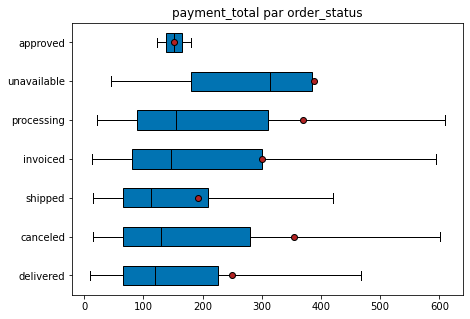

In [242]:
# Changement de la palette graphique
sns.set_palette(sns.color_palette("colorblind", 3))

X = "order_status" # qualitative
Y = "payment_total" # quantitative
sous_echantillon = data[data["payment_total"] > 0].copy()
modalites = sous_echantillon[X].unique()
groupes = []

for m in modalites:
    groupes.append(sous_echantillon[sous_echantillon[X]==m][Y])
    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'} #la moyenne des valeurs.
    
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.title("payment_total par order_status")


plt.show()

In [243]:
X = "order_status" # qualitative
Y = "payment_total" # quantitative

eta_squared(sous_echantillon[X],sous_echantillon[Y]) #[0,1]

0.0002376764058369256

**Les autres produits non encore délivrés représente des montants importants dans `payment_total` même si ils représentent une minorité.**

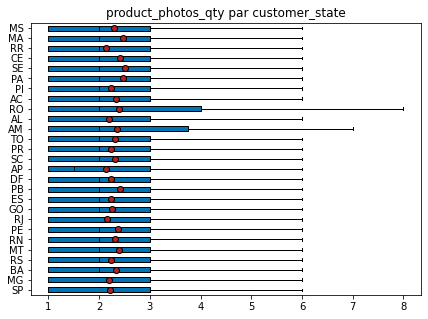

In [244]:
# Changement de la palette graphique
sns.set_palette(sns.color_palette("colorblind", 3))

X = "customer_state" # qualitative
Y = "product_photos_qty" # quantitative

sous_echantillon = data[data["product_photos_qty"] > 0].copy()
modalites = sous_echantillon[X].unique()
groupes = []

for m in modalites:
    groupes.append(sous_echantillon[sous_echantillon[X]==m][Y])
    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'} #la moyenne des valeurs.
    
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.title("product_photos_qty par customer_state")


plt.show()

In [245]:
X = "customer_state" # qualitative
Y = "product_photos_qty" # quantitative

eta_squared(sous_echantillon[X],sous_echantillon[Y]) #[0,1]

0.0013474190450891142

## <font color="#337da4">Analyse bi-variée entre 2 variables qualitatives</font>

In [246]:
data.head()

,product_category_name,product_category_name_english,order_id,product_id,price,freight_value,payment_sequential,payment_type,review_score,order_status,order_purchase_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,most_payment_type,order_count,payment_total,part_day,distances_km,diff_days_to_deliver,diff_days_estimated-delivered
0,beleza_saude,health_beauty,0005a1a1728c9d785b8e2b08b904576c,310ae3c140ff94b03219ad0adc3c778f,145.95,11.65,1.0,credit_card,1,delivered,2018-03-19 18:40:33,59.0,493.0,1.0,639d23421f5517f69d0c3d6e6564cf0e,11075,santos,SP,3702,sao paulo,SP,credit_card,1,157.60,night,52.44,9.0,-1.0
1,beleza_saude,health_beauty,130aa16eb157e7606fcafbd807c8048e,dfac7527b7d46b412ac29dcabad2f619,113.00,20.28,1.0,credit_card,5,delivered,2017-12-03 17:28:57,38.0,1018.0,1.0,742405ae9634962bb67f54214a8247c9,33400,lagoa santa,MG,3702,sao paulo,SP,credit_card,1,133.28,afternoon,515.11,10.0,14.0
2,beleza_saude,health_beauty,00d831d5c3ea03b7cd6f883ad799c7e4,eb2d12bc991561d4ca5deff0e60854e4,128.90,9.26,1.0,credit_card,5,delivered,2018-03-12 11:56:58,48.0,333.0,1.0,b813fe59b2d10fb59d5594ec8f91750e,5716,sao paulo,SP,3702,sao paulo,SP,credit_card,1,138.16,morning,22.86,4.0,8.0
3,beleza_saude,health_beauty,00e7aeced1d61792368ec7bf8b967a90,65e3848513c9ab70bf542e5d694cf072,36.85,21.85,1.0,boleto,4,delivered,2017-04-13 02:11:17,46.0,1001.0,1.0,c76c0ebec1c44b44dca88e42b23149f1,41815,salvador,BA,3702,sao paulo,SP,boleto,1,58.70,late_nignt,1447.41,21.0,12.0
4,beleza_saude,health_beauty,01c139e11e826da7bf9782cf1ee904bf,11bbef4e2a44601d9dd471aa1fb433e6,339.99,12.99,1.0,credit_card,4,delivered,2017-03-05 19:25:45,52.0,1222.0,2.0,c4750b080e135d87328222826982fe39,14460,cristais paulista,SP,3702,sao paulo,SP,credit_card,1,352.98,night,357.70,8.0,12.0


In [247]:
categorical_features = data.select_dtypes(exclude=['int64','float64']) 
categorical_features.describe(include="object").transpose()

,count,unique,top,freq
product_category_name,99027,71,cama_mesa_banho,10058
product_category_name_english,99027,71,bed_bath_table,10058
order_id,99027,95403,ca3625898fbd48669d50701aba51cd5f,8
product_id,99027,31701,99a4788cb24856965c36a24e339b6058,466
payment_type,99026,4,credit_card,75243
order_status,99027,7,delivered,96906
order_purchase_timestamp,99027,94884,2018-08-12 02:11:20,8
customer_unique_id,99027,92340,8d50f5eadf50201ccdcedfb9e2ac8455,15
customer_zip_code_prefix,99027,14709,22790,138
customer_city,99027,4017,sao paulo,15551


In [248]:
X = "part_day"
Y = "review_score"

c = data[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len)
cont = c.copy()
tx = data[X].value_counts()
ty = data[Y].value_counts()
cont.loc[:,"Total"] = tx
cont.loc["total",:] = ty
cont.loc["total","Total"] = len(data) # Ce comptage se fait grâce à la fonction  len  .

cont

review_score,1,2,3,4,5,Total
part_day,,,,,,
afternoon,3797.0,1072.0,2721.0,6240.0,18476.0,32306.0
late_nignt,683.0,153.0,400.0,858.0,2653.0,4747.0
morning,3302.0,902.0,2313.0,5334.0,16089.0,27940.0
night,4046.0,1206.0,2893.0,6474.0,19415.0,34034.0
total,11828.0,3333.0,8327.0,18906.0,56633.0,99027.0


**Test du χ2 d'indépendance**. \
Ce test permet de vérifier l'absence de lien statistique entre deux variables X et Y. 

**L'hypothèse nulle (H0) de ce test est la suivante : les deux variables X et Y sont indépendantes.**

En termes de valeur p, **l'hypothèse nulle est généralement rejetée lorsque p ≤ 0,05.**

In [249]:
from scipy import stats as st

#test du χ2 d'indépendance 
st_chi2, st_p, st_dof, st_exp = st.chi2_contingency(cont)
st_p # 0.01 < 0,05

0.011207238126346174

p_value obtenue par notre échantillon est de 0.01, ce qui est en dessous du seuil fixé de 5%. \
On peut donc **rejetter l’hypothèse nulle donc les variables sont corrélées.**


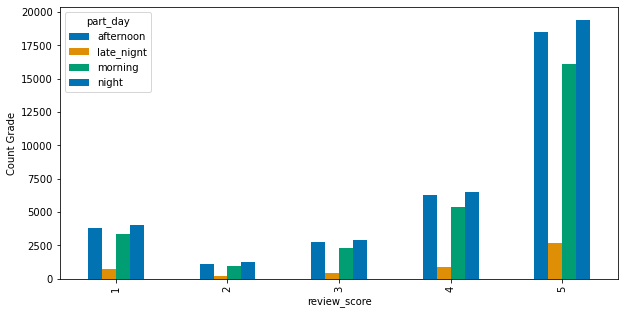

In [250]:
plt.rcParams['figure.figsize'] = (10,5)
ax = c.T.plot(kind='bar')
ylab = ax.set_ylabel('Count Grade')

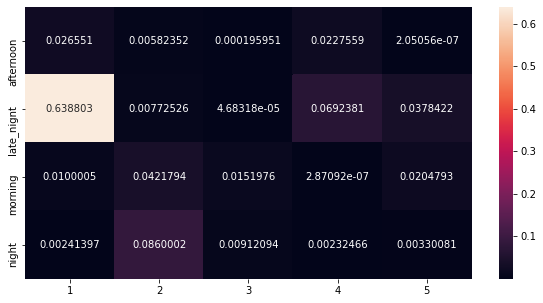

In [251]:
#calculent le tableau  indep  
tx = pd.DataFrame(tx)
ty = pd.DataFrame(ty)
tx.columns = ["foo"]
ty.columns = ["foo"]
n = len(data)

#matrix calculation == array representing the independence case.
indep = tx.dot(ty.T) / n
#we replace the null values by 0
c = c.fillna(0) 

#ξij for each cell of the table
mesure = (c-indep)**2/indep 
#ξn:  sum of rows and columns of each xi 
xi_n = mesure.sum().sum()  

#calculation of the contribution to non-independence. 
sns.heatmap((mesure/xi_n),annot=True,  fmt='g') #chaque ξij en le divisant par ξn . entre 0 et 1.
plt.show()

Foncé quand la mesure est grande donc proche de 1 > pas indépendant > dépendant\
Clair quand elle est proche de 0  >  indépendant

**<font color="green">Les personnes qui notent tardivement dans la nuit donnent la note de 1 avec une corrélation de 0,64.</font>**

In [252]:
X = "most_payment_type"
Y = "review_score"

c = data[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len)
cont = c.copy()
tx = data[X].value_counts()
ty = data[Y].value_counts()

cont.loc[:,"Total"] = tx
cont.loc["total",:] = ty
cont.loc["total","Total"] = len(data) 

cont

review_score,1,2,3,4,5,Total
most_payment_type,,,,,,
boleto,2250.0,641.0,1694.0,3761.0,11002.0,19348.0
credit_card,8936.0,2483.0,6148.0,14140.0,42465.0,74172.0
debit_card,162.0,50.0,117.0,292.0,950.0,1571.0
voucher,479.0,159.0,368.0,713.0,2216.0,3935.0
total,11828.0,3333.0,8327.0,18906.0,56633.0,99027.0


In [253]:
#test du χ2 d'indépendance 
st_chi2, st_p, st_dof, st_exp = st.chi2_contingency(cont)
st_p  # 0.08 > 0,05

0.08995545102774342

p_value obtenue par notre échantillon est de 0.09, ce qui est en dessus du seuil fixé de 5%. \
On peut donc **accepte l’hypothèse nulle donc les variables sont indépendantes.**


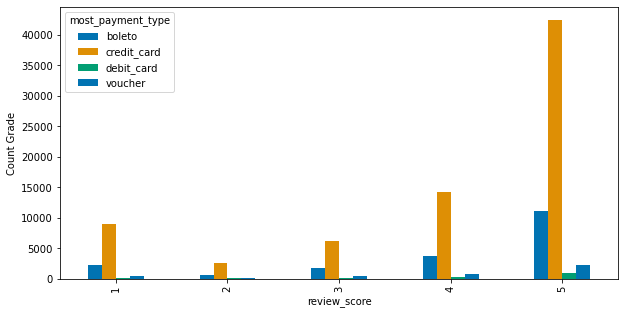

In [254]:
plt.rcParams['figure.figsize'] = (10,5)
ax = c.T.plot(kind='bar')
ylab = ax.set_ylabel('Count Grade')

Les clients qui  payent par carte sont plus actifs dans les reviews.

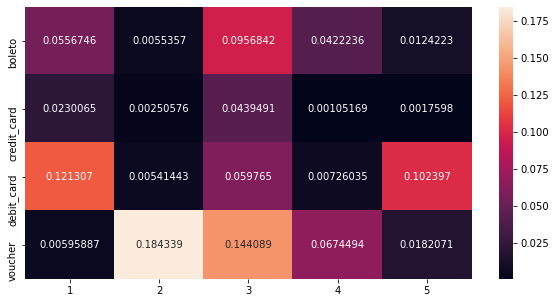

In [255]:
#calculent le tableau  indep  

tx = pd.DataFrame(tx)
ty = pd.DataFrame(ty)
tx.columns = ["foo"]
ty.columns = ["foo"]

n = len(data)

#matrix calculation == array representing the independence case.
indep = tx.dot(ty.T) / n

c = c.fillna(0) # on remplace les valeurs nulles par des 0

#Each ξij for each cell of the table
mesure = (c-indep)**2/indep 
#ξn: sum of rows and columns of each xi 
xi_n = mesure.sum().sum()  

#calculation of the contribution to non-independence. 
sns.heatmap((mesure/xi_n),annot=True,  fmt='g') #between 0 and 1.
plt.show()

Clair quand la mesure est proche de 1 , ==  dépendant \
Fonce quand elle est proche de 0.              == indépendant \
Chaque case une valeur comprise entre 0 et 1.


**La note 2 et 3  dépendent des paiement par voucher (bons d'achat).**\
**La note 1 et 5  dépendent des paiement par debit_carte (bons d'achat).**

In [256]:
X = "order_status"
Y = "review_score"
c = data[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len)
cont = c.copy()

tx = data[X].value_counts()
ty = data[Y].value_counts()

cont.loc[:,"Total"] = tx
cont.loc["total",:] = ty
cont.loc["total","Total"] = len(data) # Ce comptage se fait grâce à la fonction  len  .
cont

review_score,1,2,3,4,5,Total
order_status,,,,,,
approved,1.0,NaN,NaN,1.0,NaN,2.0
canceled,339.0,24.0,30.0,14.0,35.0,442.0
delivered,10339.0,3181.0,8161.0,18785.0,56440.0,96906.0
invoiced,226.0,27.0,15.0,13.0,25.0,306.0
processing,248.0,18.0,9.0,5.0,7.0,287.0
shipped,669.0,83.0,112.0,88.0,125.0,1077.0
unavailable,6.0,NaN,NaN,NaN,1.0,7.0
total,11828.0,3333.0,8327.0,18906.0,56633.0,99027.0


In [257]:
data[data["review_score"].isna()].head()

,product_category_name,product_category_name_english,order_id,product_id,price,freight_value,payment_sequential,payment_type,review_score,order_status,order_purchase_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,most_payment_type,order_count,payment_total,part_day,distances_km,diff_days_to_deliver,diff_days_estimated-delivered


In [258]:
#χ2 indépendance test
st_chi2, st_p, st_dof, st_exp = st.chi2_contingency(cont)
st_p 

nan

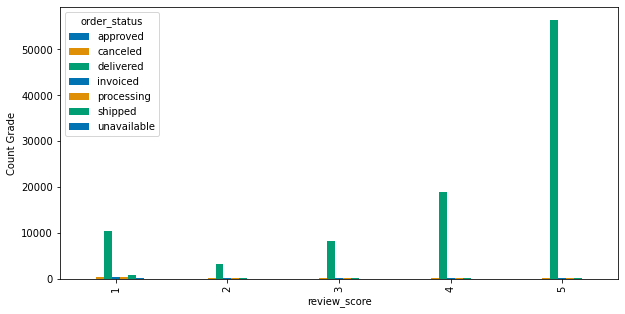

In [259]:
plt.rcParams['figure.figsize'] = (10,5)
ax = c.T.plot(kind='bar')
ylab = ax.set_ylabel('Count Grade')

In [260]:
X = "customer_state"
Y = "review_score"
c = data[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len)
cont = c.copy()
tx = data[X].value_counts()
ty = data[Y].value_counts()
cont.loc[:,"Total"] = tx
cont.loc["total",:] = ty
cont.loc["total","Total"] = len(data) # Ce comptage se fait grâce à la fonction  len  .
cont

review_score,1,2,3,4,5,Total
customer_state,,,,,,
AC,7.0,7.0,8.0,15.0,42.0,79.0
AL,75.0,24.0,30.0,85.0,195.0,409.0
AM,13.0,10.0,6.0,30.0,91.0,150.0
AP,4.0,2.0,9.0,19.0,36.0,70.0
BA,535.0,138.0,340.0,726.0,1616.0,3355.0
CE,214.0,53.0,133.0,261.0,665.0,1326.0
DF,246.0,65.0,164.0,402.0,1093.0,1970.0
ES,276.0,61.0,184.0,427.0,1098.0,2046.0
GO,240.0,72.0,193.0,409.0,1088.0,2002.0


In [261]:
from scipy import stats as st

st_chi2, st_p, st_dof, st_exp = st.chi2_contingency(cont)
st_p #1.78 > 0,05

1.7894579168716402e-149

p_value obtenue par notre échantillon est de 1,79e-149, ce qui est en dessous du seuil fixé de 5%. \
On peut donc **rejetter l’hypothèse nulle donc les variables sont dépendantes.**

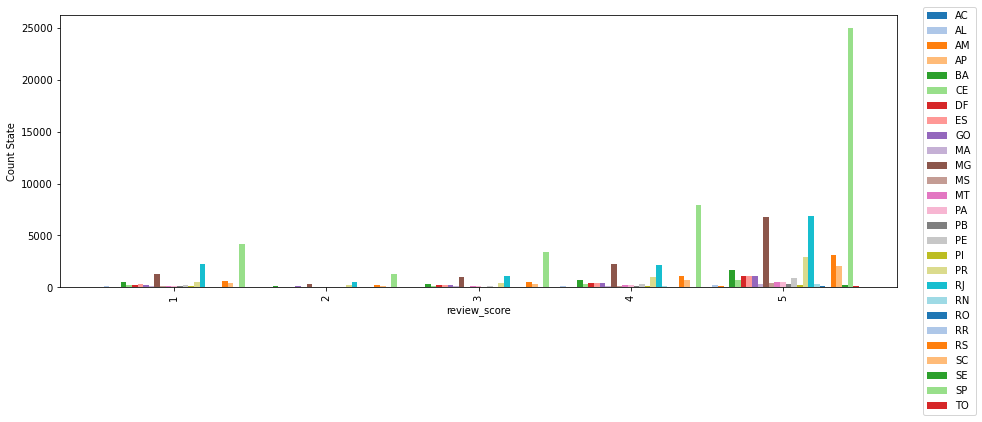

In [262]:
plt.rcParams['figure.figsize'] = (15, 5) 

majors =['SP', 'MG', 'BA', 
         'RS', 'MT', 'RN', 
         'PE', 'RJ', 'GO', 
         'ES', 'PB','DF', 
         'AP', 'SC', 'PR', 
         'TO', 'AM', 'AL', 
         'RO', 'AC', 'PI',
         'PA','SE', 'CE', 
         'RR', 'MA', 'MS']

color_sequence = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
                  '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5',
                 '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
                 '#98df8a', '#d62728']

ax = c.T.plot(kind='bar', width = 1, color=color_sequence )
ax.set_ylabel('Count State')
ax.legend(bbox_to_anchor=(1.1, 1.05),fontsize = 10)

Pour les noms des Etats :https://brazil-help.com/brazilian_states.htm

**<font color="green">Les pays majoritaires dans la notation sont SP Sao Paulo - vert, MG Minas Gerais - marron, RJ Rio de Janeiro - bleu.</font>**

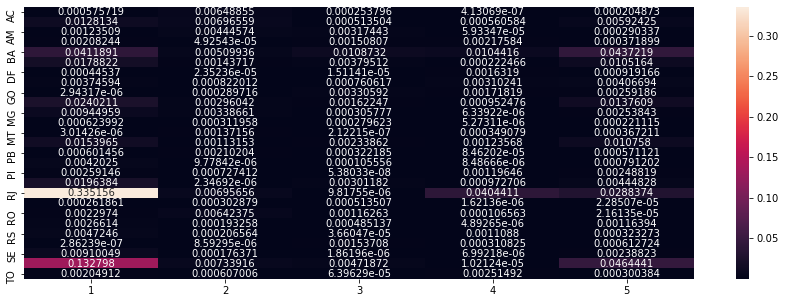

In [263]:
#calculate the indep table   
tx = pd.DataFrame(tx)
ty = pd.DataFrame(ty)
tx.columns = ["foo"]
ty.columns = ["foo"]
n = len(data)
#matrix calculation == array representing the independence case.
indep = tx.dot(ty.T) / n
c = c.fillna(0) # on remplace les valeurs nulles par des 0
#Each ξij for each cell of the table
mesure = (c-indep)**2/indep 
# #ξn: sum of rows and columns of each xi 
xi_n = mesure.sum().sum()  
#calculation of the contribution to non-independence. .
sns.heatmap((mesure/xi_n),annot=True,  fmt='g') #chaque ξij en le divisant par ξn . entre 0 et 1.
plt.show()

**<font color="green">Aracajú SE et Rio de Janeiro RJ sont fortement correlés à la note 1.</font>**

In [264]:
X = "customer_state"
Y = "part_day"

c = data[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len)
cont = c.copy()

tx = data[X].value_counts()
ty = data[Y].value_counts()

cont.loc[:,"Total"] = tx
cont.loc["total",:] = ty
cont.loc["total","Total"] = len(data) # Ce comptage se fait grâce à la fonction  len  .
cont

part_day,afternoon,late_nignt,morning,night,Total
customer_state,,,,,
AC,31.0,12.0,8.0,28.0,79.0
AL,126.0,26.0,113.0,144.0,409.0
AM,59.0,11.0,29.0,51.0,150.0
AP,22.0,6.0,18.0,24.0,70.0
BA,1063.0,186.0,892.0,1214.0,3355.0
CE,396.0,46.0,433.0,451.0,1326.0
DF,655.0,81.0,560.0,674.0,1970.0
ES,647.0,89.0,601.0,709.0,2046.0
GO,675.0,85.0,590.0,652.0,2002.0


In [265]:
from scipy import stats as st

st_chi2, st_p, st_dof, st_exp = st.chi2_contingency(cont)
st_p 

4.1022254676345156e-20

p_value obtenue par notre échantillon est de 4.10e-20, ce qui est en dessous du seuil fixé de 5%. \
On peut donc **rejette l’hypothèse nulle donc les variables sont dépendantes.**

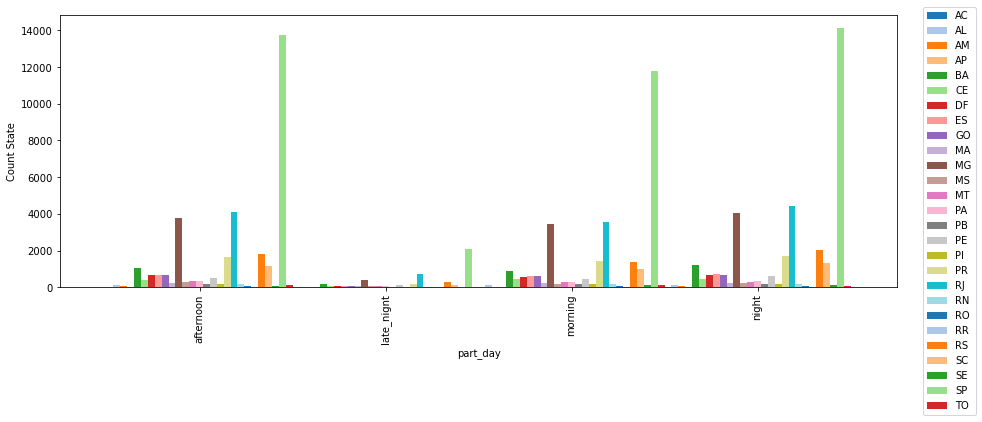

In [266]:
plt.rcParams['figure.figsize'] = (15, 5) 

majors =['SP', 'MG', 'BA', 
         'RS', 'MT', 'RN', 
         'PE', 'RJ', 'GO', 
         'ES', 'PB','DF', 
         'AP', 'SC', 'PR', 
         'TO', 'AM', 'AL', 
         'RO', 'AC', 'PI',
         'PA','SE', 'CE', 
         'RR', 'MA', 'MS']

color_sequence = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
                  '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5',
                 '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
                 '#98df8a', '#d62728']

ax = c.T.plot(kind='bar', width = 1, color=color_sequence )
ax.set_ylabel('Count State')
ax.legend(bbox_to_anchor=(1.1, 1.05),fontsize = 10)

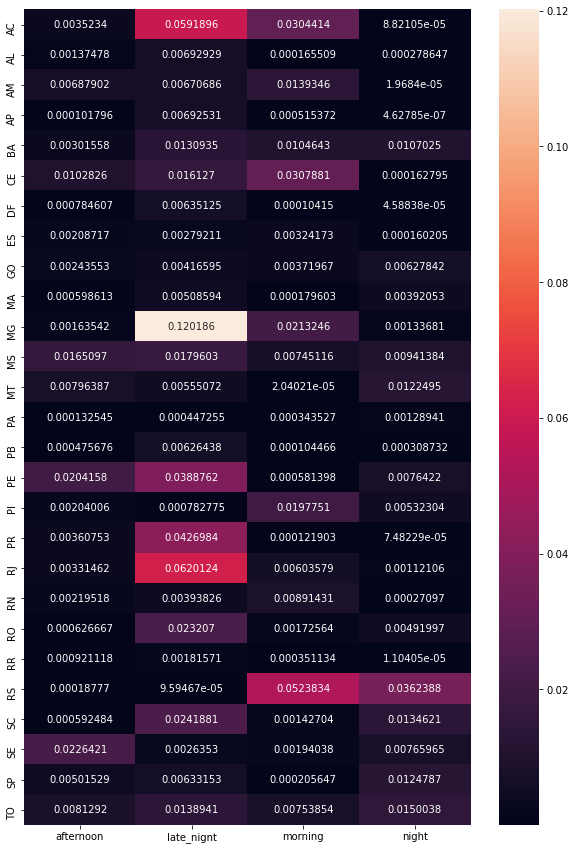

In [267]:
plt.rcParams['figure.figsize'] = (10, 15)
#calculate the indep table   
tx = pd.DataFrame(tx)
ty = pd.DataFrame(ty)

tx.columns = ["foo"]
ty.columns = ["foo"]
n = len(data)

#matrix calculation == array representing the independence case.
indep = tx.dot(ty.T) / n
c = c.fillna(0) # on remplace les valeurs nulles par des 0
#Each ξij for each cell of the table
mesure = (c-indep)**2/indep 
# #ξn: sum of rows and columns of each xi 
xi_n = mesure.sum().sum()  
#calculation of the contribution to non-independence. .
sns.heatmap((mesure/xi_n),annot=True,  fmt='g') #chaque ξij en le divisant par ξn . entre 0 et 1.
plt.show()

**<font color="green">MG, Minas Gerais et RJ, Rio de Janeiro sont fortement correlés à late_night.</font>**


## <font color="#337da4">Hypothèses</font>

Les variables les plus corrélées à `payment_total`sont **`order_count`** et  **`price`**.



Les variables dépendantes sont : 

**`review_score`** et  **`part_day`**  
**`review_score`** et  `customer_state` \
**`part_day`** et `customer_state` . 

Les variables citées ci-dessus sont susceptibles d'expliquer la formation des clusters.

# <font color="#1d479b">Nettoyage avant modelisation</font>

## <font color="#337da4">Imputation des NaN</font>

In [268]:
data.isna().sum()

product_category_name               0
product_category_name_english       0
order_id                            0
product_id                          0
price                               0
freight_value                       0
payment_sequential                  1
payment_type                        1
review_score                        0
order_status                        0
order_purchase_timestamp            0
product_name_lenght                 0
product_description_lenght          0
product_photos_qty                  0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
seller_zip_code_prefix              0
seller_city                         0
seller_state                        0
most_payment_type                   1
order_count                         0
payment_total                       0
part_day                            0
distances_km                        0
diff_days_to

In [269]:
data[data["payment_type"].isna()]

,product_category_name,product_category_name_english,order_id,product_id,price,freight_value,payment_sequential,payment_type,review_score,order_status,order_purchase_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,most_payment_type,order_count,payment_total,part_day,distances_km,diff_days_to_deliver,diff_days_estimated-delivered
101489,beleza_saude,health_beauty,bfbd0f9bdef84302105ad712db648a6c,5a6b04657a4c5ee34285d1e4619a96b4,44.99,2.83,NaN,NaN,1,delivered,2016-09-15 12:16:38,34.0,1036.0,1.0,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP,81810,curitiba,PR,NaN,3,0.0,morning,566.49,54.0,-37.0


In [270]:
data = data.dropna(subset=['payment_type', 'payment_sequential'])
data.shape

(99026, 28)

In [271]:
data.isna().sum()

product_category_name               0
product_category_name_english       0
order_id                            0
product_id                          0
price                               0
freight_value                       0
payment_sequential                  0
payment_type                        0
review_score                        0
order_status                        0
order_purchase_timestamp            0
product_name_lenght                 0
product_description_lenght          0
product_photos_qty                  0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
seller_zip_code_prefix              0
seller_city                         0
seller_state                        0
most_payment_type                   0
order_count                         0
payment_total                       0
part_day                            0
distances_km                        0
diff_days_to

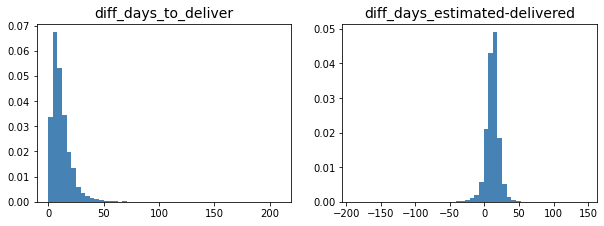

In [272]:
#distribution before imputation

fig = plt.figure(figsize=(21, 19))

to_impute = data[["diff_days_to_deliver","diff_days_estimated-delivered"]]#df
X = to_impute.values #array

for feat_idx in range(X.shape[1]):
    ax = fig.add_subplot(5,4, (feat_idx+1))
    h = ax.hist(X[:, feat_idx], bins=50, color='steelblue', density=True, edgecolor='none')  
    ax.set_title(to_impute.columns[feat_idx], fontsize=14)

In [273]:
from sklearn.impute import KNNImputer

to_impute = data[["diff_days_to_deliver","diff_days_estimated-delivered"]]
imputer = KNNImputer(n_neighbors=2)                                      
to_impute = pd.DataFrame(imputer.fit_transform(to_impute),columns=list(to_impute.columns)) 

<AxesSubplot:>

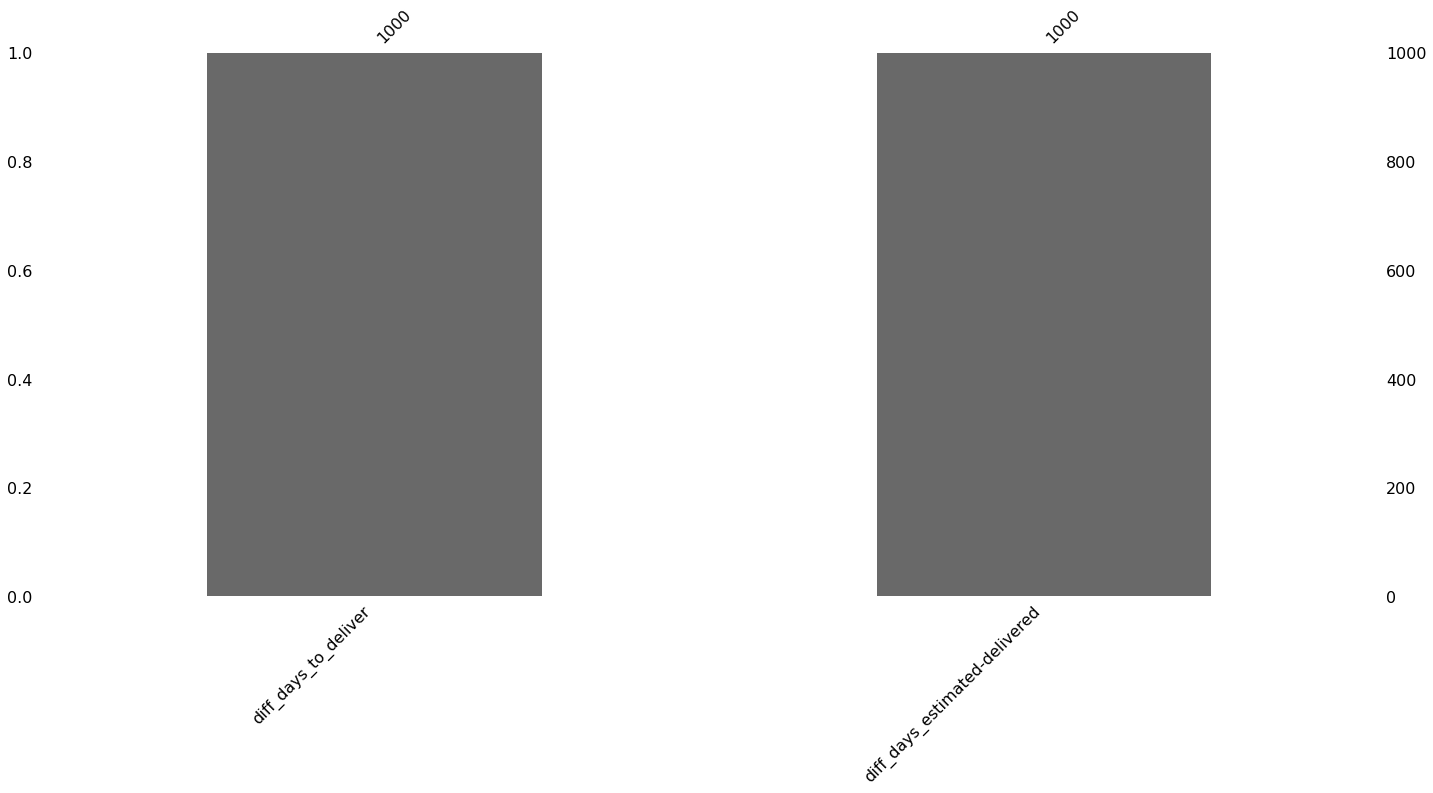

In [274]:
import missingno as msno
msno.bar(to_impute.sample(1000))

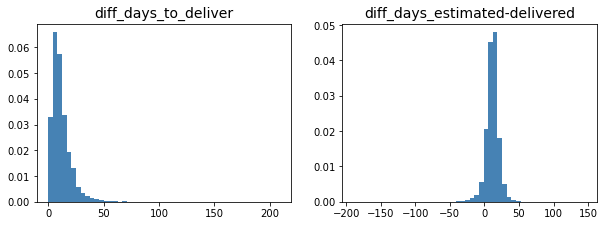

In [275]:
#Vérification distribution après imputation
fig = plt.figure(figsize=(21, 19))

X = to_impute.values #array

for feat_idx in range(X.shape[1]):
    ax = fig.add_subplot(5,4, (feat_idx+1))
    h = ax.hist(X[:, feat_idx], bins=50, color='steelblue', density=True, edgecolor='none')  
    ax.set_title(to_impute.columns[feat_idx], fontsize=14)

**L'imputation par itérative imputer ou KNNImputer n'a pas modifié la distribution.**

In [276]:
#Replacement of columns
data.loc[data.index.isin(to_impute.index), ["diff_days_to_deliver","diff_days_estimated-delivered"]] = to_impute[["diff_days_to_deliver","diff_days_estimated-delivered"]]

<AxesSubplot:>

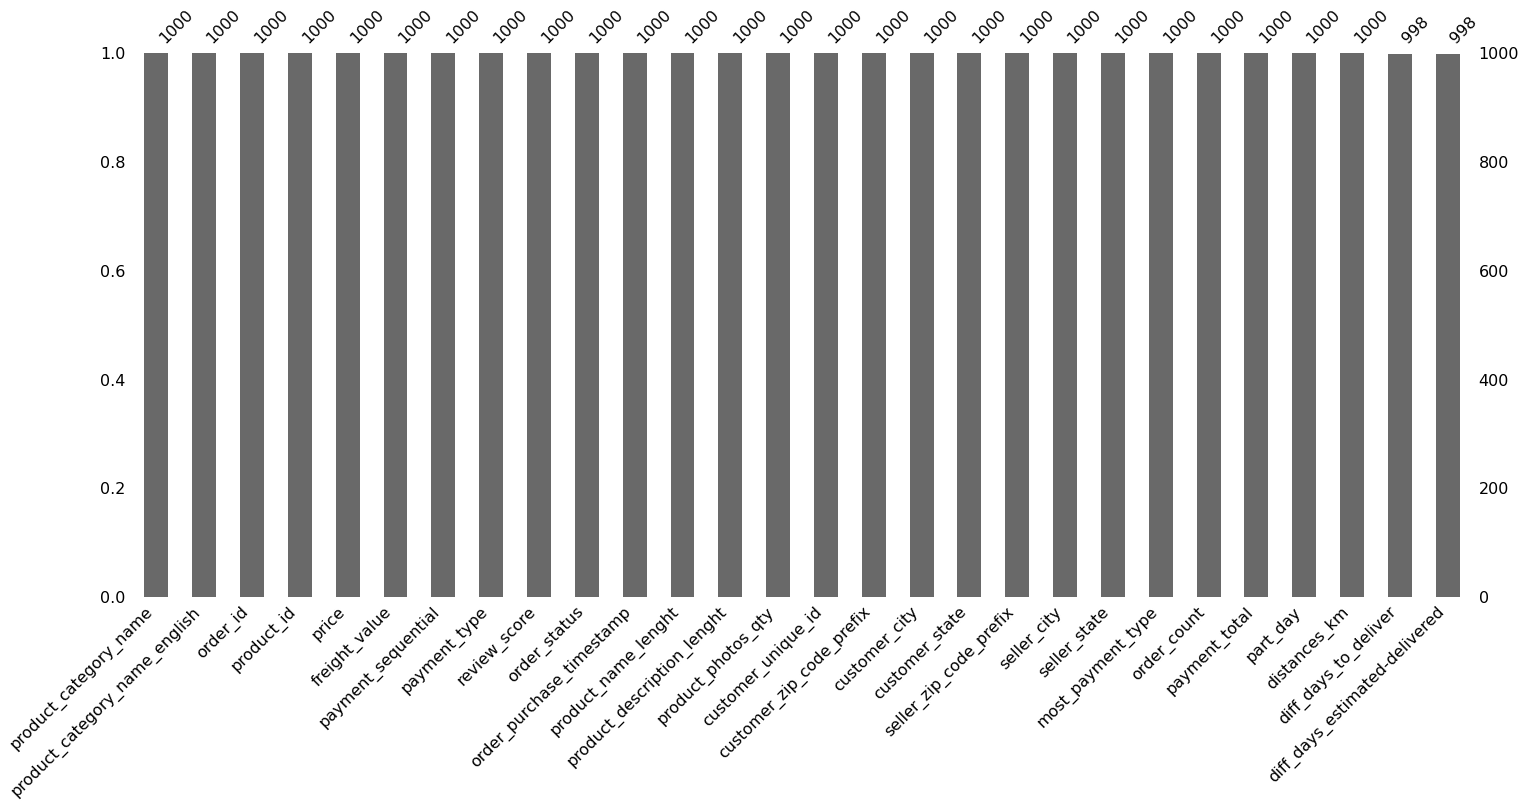

In [277]:
msno.bar(data.sample(1000))

In [278]:
data.isna().sum()

product_category_name              0
product_category_name_english      0
order_id                           0
product_id                         0
price                              0
freight_value                      0
payment_sequential                 0
payment_type                       0
review_score                       0
order_status                       0
order_purchase_timestamp           0
product_name_lenght                0
product_description_lenght         0
product_photos_qty                 0
customer_unique_id                 0
customer_zip_code_prefix           0
customer_city                      0
customer_state                     0
seller_zip_code_prefix             0
seller_city                        0
seller_state                       0
most_payment_type                  0
order_count                        0
payment_total                      0
part_day                           0
distances_km                       0
diff_days_to_deliver             464
d

Que ce soit par la méthode IterativeImputer ou KNN imputer, il reste toujours quelques NaN. On va les laisser pour l'instant.

In [283]:
print(data.shape)
data.head()

(99026, 28)


,product_category_name,product_category_name_english,order_id,product_id,price,freight_value,payment_sequential,payment_type,review_score,order_status,order_purchase_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,most_payment_type,order_count,payment_total,part_day,distances_km,diff_days_to_deliver,diff_days_estimated-delivered
0,beleza_saude,health_beauty,0005a1a1728c9d785b8e2b08b904576c,310ae3c140ff94b03219ad0adc3c778f,145.95,11.65,1.0,credit_card,1,delivered,2018-03-19 18:40:33,59.0,493.0,1.0,639d23421f5517f69d0c3d6e6564cf0e,11075,santos,SP,3702,sao paulo,SP,credit_card,1,157.60,night,52.44,9.0,-1.0
1,beleza_saude,health_beauty,130aa16eb157e7606fcafbd807c8048e,dfac7527b7d46b412ac29dcabad2f619,113.00,20.28,1.0,credit_card,5,delivered,2017-12-03 17:28:57,38.0,1018.0,1.0,742405ae9634962bb67f54214a8247c9,33400,lagoa santa,MG,3702,sao paulo,SP,credit_card,1,133.28,afternoon,515.11,10.0,14.0
2,beleza_saude,health_beauty,00d831d5c3ea03b7cd6f883ad799c7e4,eb2d12bc991561d4ca5deff0e60854e4,128.90,9.26,1.0,credit_card,5,delivered,2018-03-12 11:56:58,48.0,333.0,1.0,b813fe59b2d10fb59d5594ec8f91750e,5716,sao paulo,SP,3702,sao paulo,SP,credit_card,1,138.16,morning,22.86,4.0,8.0
3,beleza_saude,health_beauty,00e7aeced1d61792368ec7bf8b967a90,65e3848513c9ab70bf542e5d694cf072,36.85,21.85,1.0,boleto,4,delivered,2017-04-13 02:11:17,46.0,1001.0,1.0,c76c0ebec1c44b44dca88e42b23149f1,41815,salvador,BA,3702,sao paulo,SP,boleto,1,58.70,late_nignt,1447.41,21.0,12.0
4,beleza_saude,health_beauty,01c139e11e826da7bf9782cf1ee904bf,11bbef4e2a44601d9dd471aa1fb433e6,339.99,12.99,1.0,credit_card,4,delivered,2017-03-05 19:25:45,52.0,1222.0,2.0,c4750b080e135d87328222826982fe39,14460,cristais paulista,SP,3702,sao paulo,SP,credit_card,1,352.98,night,357.70,8.0,12.0


Il reste quelques que NaN.. nous gardons le dataset tel quel pour le moment.

In [280]:
data.to_csv("3.csv",index=False)

## <font color="#337da4">Normalisation</font>

In [281]:
data = pd.read_csv("3.csv")
print(data.shape)
data.head()

(99026, 28)


,product_category_name,product_category_name_english,order_id,product_id,price,freight_value,payment_sequential,payment_type,review_score,order_status,order_purchase_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,most_payment_type,order_count,payment_total,part_day,distances_km,diff_days_to_deliver,diff_days_estimated-delivered
0,beleza_saude,health_beauty,0005a1a1728c9d785b8e2b08b904576c,310ae3c140ff94b03219ad0adc3c778f,145.95,11.65,1.0,credit_card,1,delivered,2018-03-19 18:40:33,59.0,493.0,1.0,639d23421f5517f69d0c3d6e6564cf0e,11075,santos,SP,3702,sao paulo,SP,credit_card,1,157.60,night,52.44,9.0,-1.0
1,beleza_saude,health_beauty,130aa16eb157e7606fcafbd807c8048e,dfac7527b7d46b412ac29dcabad2f619,113.00,20.28,1.0,credit_card,5,delivered,2017-12-03 17:28:57,38.0,1018.0,1.0,742405ae9634962bb67f54214a8247c9,33400,lagoa santa,MG,3702,sao paulo,SP,credit_card,1,133.28,afternoon,515.11,10.0,14.0
2,beleza_saude,health_beauty,00d831d5c3ea03b7cd6f883ad799c7e4,eb2d12bc991561d4ca5deff0e60854e4,128.90,9.26,1.0,credit_card,5,delivered,2018-03-12 11:56:58,48.0,333.0,1.0,b813fe59b2d10fb59d5594ec8f91750e,5716,sao paulo,SP,3702,sao paulo,SP,credit_card,1,138.16,morning,22.86,4.0,8.0
3,beleza_saude,health_beauty,00e7aeced1d61792368ec7bf8b967a90,65e3848513c9ab70bf542e5d694cf072,36.85,21.85,1.0,boleto,4,delivered,2017-04-13 02:11:17,46.0,1001.0,1.0,c76c0ebec1c44b44dca88e42b23149f1,41815,salvador,BA,3702,sao paulo,SP,boleto,1,58.70,late_nignt,1447.41,21.0,12.0
4,beleza_saude,health_beauty,01c139e11e826da7bf9782cf1ee904bf,11bbef4e2a44601d9dd471aa1fb433e6,339.99,12.99,1.0,credit_card,4,delivered,2017-03-05 19:25:45,52.0,1222.0,2.0,c4750b080e135d87328222826982fe39,14460,cristais paulista,SP,3702,sao paulo,SP,credit_card,1,352.98,night,357.70,8.0,12.0


In [282]:
#Typage
list_column2 = ["customer_zip_code_prefix",
               'seller_zip_code_prefix']

data[list_column2] = data[list_column2].astype('object')

In [286]:
#Typage
list_column = ["order_purchase_timestamp"]

data[list_column] = data[list_column].astype('datetime64[ns]')

In [287]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99026 entries, 0 to 99025
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   product_category_name          99026 non-null  object        
 1   product_category_name_english  99026 non-null  object        
 2   order_id                       99026 non-null  object        
 3   product_id                     99026 non-null  object        
 4   price                          99026 non-null  float64       
 5   freight_value                  99026 non-null  float64       
 6   payment_sequential             99026 non-null  float64       
 7   payment_type                   99026 non-null  object        
 8   review_score                   99026 non-null  int64         
 9   order_status                   99026 non-null  object        
 10  order_purchase_timestamp       99026 non-null  datetime64[ns]
 11  product_name_le

In [288]:
numeric_features = data.select_dtypes(include=['int64','float64'])
numeric_features.head()

,price,freight_value,payment_sequential,review_score,product_name_lenght,product_description_lenght,product_photos_qty,order_count,payment_total,distances_km,diff_days_to_deliver,diff_days_estimated-delivered
0,145.95,11.65,1.0,1,59.0,493.0,1.0,1,157.60,52.44,9.0,-1.0
1,113.00,20.28,1.0,5,38.0,1018.0,1.0,1,133.28,515.11,10.0,14.0
2,128.90,9.26,1.0,5,48.0,333.0,1.0,1,138.16,22.86,4.0,8.0
3,36.85,21.85,1.0,4,46.0,1001.0,1.0,1,58.70,1447.41,21.0,12.0
4,339.99,12.99,1.0,4,52.0,1222.0,2.0,1,352.98,357.70,8.0,12.0


In [290]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit(numeric_features)
X_scaled = scaler.transform(numeric_features)
X_scaled

array([[ 0.11259779, -0.53343322, -0.09470619, ..., -0.91903945,
        -0.310797  , -1.18738756],
       [-0.06178856,  0.00942477, -0.09470619, ..., -0.1448065 ,
        -0.20470967,  0.29305598],
       [ 0.02236145, -0.6837728 , -0.09470619, ..., -0.96853868,
        -0.84123363, -0.29912144],
       ...,
       [-0.45343015, -0.21010876, -0.09470619, ...,  0.92869768,
         1.28051289,  1.37871458],
       [ 1.03322015, -0.19752805, -0.09470619, ...,  0.62524295,
                nan,         nan],
       [-0.40103486, -0.13902771, -0.09470619, ...,  0.94333995,
                nan,         nan]])

In [291]:
#remplacement des valeurs. DF = array
data[list(numeric_features.columns)]= X_scaled
print(data.shape)
data.head()

(99026, 28)


,product_category_name,product_category_name_english,order_id,product_id,price,freight_value,payment_sequential,payment_type,review_score,order_status,order_purchase_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,most_payment_type,order_count,payment_total,part_day,distances_km,diff_days_to_deliver,diff_days_estimated-delivered
0,beleza_saude,health_beauty,0005a1a1728c9d785b8e2b08b904576c,310ae3c140ff94b03219ad0adc3c778f,0.11,-5.33e-01,-0.09,credit_card,-2.24,delivered,2018-03-19 18:40:33,1.01,-0.45,-0.71,639d23421f5517f69d0c3d6e6564cf0e,11075,santos,SP,3702,sao paulo,SP,credit_card,-0.32,-0.12,night,-0.92,-0.31,-1.19
1,beleza_saude,health_beauty,130aa16eb157e7606fcafbd807c8048e,dfac7527b7d46b412ac29dcabad2f619,-0.06,9.42e-03,-0.09,credit_card,0.69,delivered,2017-12-03 17:28:57,-1.09,0.36,-0.71,742405ae9634962bb67f54214a8247c9,33400,lagoa santa,MG,3702,sao paulo,SP,credit_card,-0.32,-0.15,afternoon,-0.14,-0.20,0.29
2,beleza_saude,health_beauty,00d831d5c3ea03b7cd6f883ad799c7e4,eb2d12bc991561d4ca5deff0e60854e4,0.02,-6.84e-01,-0.09,credit_card,0.69,delivered,2018-03-12 11:56:58,-0.09,-0.70,-0.71,b813fe59b2d10fb59d5594ec8f91750e,5716,sao paulo,SP,3702,sao paulo,SP,credit_card,-0.32,-0.15,morning,-0.97,-0.84,-0.30
3,beleza_saude,health_beauty,00e7aeced1d61792368ec7bf8b967a90,65e3848513c9ab70bf542e5d694cf072,-0.46,1.08e-01,-0.09,boleto,-0.05,delivered,2017-04-13 02:11:17,-0.29,0.33,-0.71,c76c0ebec1c44b44dca88e42b23149f1,41815,salvador,BA,3702,sao paulo,SP,boleto,-0.32,-0.25,late_nignt,1.42,0.96,0.10
4,beleza_saude,health_beauty,01c139e11e826da7bf9782cf1ee904bf,11bbef4e2a44601d9dd471aa1fb433e6,1.14,-4.49e-01,-0.09,credit_card,-0.05,delivered,2017-03-05 19:25:45,0.31,0.67,-0.13,c4750b080e135d87328222826982fe39,14460,cristais paulista,SP,3702,sao paulo,SP,credit_card,-0.32,0.14,night,-0.41,-0.42,0.10


In [292]:
data.to_csv("4.csv")

## <font color="#337da4">Dummies</font>

In [293]:
for col in data.select_dtypes(include='object').columns:
    print (col, ":", data[col].nunique())

product_category_name : 71
product_category_name_english : 71
order_id : 95402
product_id : 31701
payment_type : 4
order_status : 7
customer_unique_id : 92339
customer_zip_code_prefix : 14709
customer_city : 4017
customer_state : 27
seller_zip_code_prefix : 2150
seller_city : 531
seller_state : 22
most_payment_type : 4
part_day : 4


In [294]:
#We remove variables that are not useful and also contain too many terms to be encoded.
list_column = [ "product_category_name",
               "product_category_name_english",
               'order_id',
               "product_id",
               "payment_type", #== most_payment_type
               "customer_zip_code_prefix",
               "customer_city",
               "customer_state",
              "seller_zip_code_prefix",
              "seller_city",
              "seller_state"]

for col in list_column:
    data = data.drop(labels=[col], axis=1)  
    
data = data.set_index("customer_unique_id")
print(data.shape)
data.head()

(99026, 16)


,price,freight_value,payment_sequential,review_score,order_status,order_purchase_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,most_payment_type,order_count,payment_total,part_day,distances_km,diff_days_to_deliver,diff_days_estimated-delivered
customer_unique_id,,,,,,,,,,,,,,,,
639d23421f5517f69d0c3d6e6564cf0e,0.11,-5.33e-01,-0.09,-2.24,delivered,2018-03-19 18:40:33,1.01,-0.45,-0.71,credit_card,-0.32,-0.12,night,-0.92,-0.31,-1.19
742405ae9634962bb67f54214a8247c9,-0.06,9.42e-03,-0.09,0.69,delivered,2017-12-03 17:28:57,-1.09,0.36,-0.71,credit_card,-0.32,-0.15,afternoon,-0.14,-0.20,0.29
b813fe59b2d10fb59d5594ec8f91750e,0.02,-6.84e-01,-0.09,0.69,delivered,2018-03-12 11:56:58,-0.09,-0.70,-0.71,credit_card,-0.32,-0.15,morning,-0.97,-0.84,-0.30
c76c0ebec1c44b44dca88e42b23149f1,-0.46,1.08e-01,-0.09,-0.05,delivered,2017-04-13 02:11:17,-0.29,0.33,-0.71,boleto,-0.32,-0.25,late_nignt,1.42,0.96,0.10
c4750b080e135d87328222826982fe39,1.14,-4.49e-01,-0.09,-0.05,delivered,2017-03-05 19:25:45,0.31,0.67,-0.13,credit_card,-0.32,0.14,night,-0.41,-0.42,0.10


In [295]:
for col in data.select_dtypes(include='object').columns:
    print (col, ":", data[col].nunique())

order_status : 7
most_payment_type : 4
part_day : 4


In [296]:
target_features =['order_status','most_payment_type',"part_day"] 

In [297]:
#numeric variables and encoded variables
data = pd.get_dummies(data, columns = target_features )
data.dtypes

price                                   float64
freight_value                           float64
payment_sequential                      float64
review_score                            float64
order_purchase_timestamp         datetime64[ns]
product_name_lenght                     float64
product_description_lenght              float64
product_photos_qty                      float64
order_count                             float64
payment_total                           float64
distances_km                            float64
diff_days_to_deliver                    float64
diff_days_estimated-delivered           float64
order_status_approved                     uint8
order_status_canceled                     uint8
order_status_delivered                    uint8
order_status_invoiced                     uint8
order_status_processing                   uint8
order_status_shipped                      uint8
order_status_unavailable                  uint8
most_payment_type_boleto                

In [298]:
data.shape

(99026, 28)

In [299]:
#We remove variables that are not useful 
list_column = [ "order_status_approved",
               'order_status_invoiced',
               "order_status_processing",
               "order_status_shipped", #== most_payment_type
               "order_status_unavailable"]

for col in list_column:
    data = data.drop(labels=[col], axis=1)  
    
#data = data.set_index("customer_unique_id")
print(data.shape)
data.head()

(99026, 23)


,price,freight_value,payment_sequential,review_score,order_purchase_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,order_count,payment_total,distances_km,diff_days_to_deliver,diff_days_estimated-delivered,order_status_canceled,order_status_delivered,most_payment_type_boleto,most_payment_type_credit_card,most_payment_type_debit_card,most_payment_type_voucher,part_day_afternoon,part_day_late_nignt,part_day_morning,part_day_night
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,
639d23421f5517f69d0c3d6e6564cf0e,0.11,-5.33e-01,-0.09,-2.24,2018-03-19 18:40:33,1.01,-0.45,-0.71,-0.32,-0.12,-0.92,-0.31,-1.19,0,1,0,1,0,0,0,0,0,1
742405ae9634962bb67f54214a8247c9,-0.06,9.42e-03,-0.09,0.69,2017-12-03 17:28:57,-1.09,0.36,-0.71,-0.32,-0.15,-0.14,-0.20,0.29,0,1,0,1,0,0,1,0,0,0
b813fe59b2d10fb59d5594ec8f91750e,0.02,-6.84e-01,-0.09,0.69,2018-03-12 11:56:58,-0.09,-0.70,-0.71,-0.32,-0.15,-0.97,-0.84,-0.30,0,1,0,1,0,0,0,0,1,0
c76c0ebec1c44b44dca88e42b23149f1,-0.46,1.08e-01,-0.09,-0.05,2017-04-13 02:11:17,-0.29,0.33,-0.71,-0.32,-0.25,1.42,0.96,0.10,0,1,1,0,0,0,0,1,0,0
c4750b080e135d87328222826982fe39,1.14,-4.49e-01,-0.09,-0.05,2017-03-05 19:25:45,0.31,0.67,-0.13,-0.32,0.14,-0.41,-0.42,0.10,0,1,0,1,0,0,0,0,0,1


In [300]:
data.to_csv("5.csv",index=True)

# <font color="#1d479b">Sources</font>

Harvesine distance:
https://towardsdatascience.com/heres-how-to-calculate-distance-between-2-geolocations-in-python-93ecab5bbba4
